# Data Importing

Here below is where data is being imported. Glob is used to store the CSV file names in an array, allowing for easy looping through the files

In [3]:
import pandas as pd
import glob
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load all weather CSV files
csv_files = glob.glob('raw_sampled_files/*.csv')

Files are fixed and written to a new directory to fix the issue of files being formatted incorrectly. (Issue experienced with Solar column having null values)

In [5]:
for input_file in csv_files:
    output_file = input_file.replace("raw_sampled_files", "fixed_sampled_files")
    
    with open(input_file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    cleaned_lines = []
    for line in lines:
        # Remove all quote characters
        line = line.replace('"', '').replace("'", "")
        # Remove trailing commas and whitespace/newline, then re-add newline
        line = line.rstrip(",\n") + "\n"
        cleaned_lines.append(line)

    with open(output_file, "w", encoding="utf-8") as f:
        f.writelines(cleaned_lines)

A list of df objects are created using Glob to allow for easy iteration later

In [7]:
fixed_sampled_files = glob.glob('fixed_sampled_files/*.csv')  

df_list = [pd.read_csv(file) for file in fixed_sampled_files]

print(f"Loaded {len(df_list)} files")

Loaded 60 files


# EDA (Exploratory Data Analysis)

The first file in the dataframe list is used for our EDA

In [10]:
eda_df = df_list[0]
print(f"df shape: {eda_df.shape}")

df shape: (12987, 10)


In [11]:
# Handle missing values
eda_df = eda_df.dropna()
eda_df.head(5)

Date  Longitude  Latitude  Elevation  Max Temperature  Min Temperature  \
0  1/1/1979     24.375   -12.333       1240           29.094           15.541   
1  1/2/1979     24.375   -12.333       1240           26.951           14.185   
2  1/3/1979     24.375   -12.333       1240           26.295           16.389   
3  1/4/1979     24.375   -12.333       1240           22.602           15.954   
4  1/5/1979     24.375   -12.333       1240           22.462           15.278   

   Precipitation      Wind  Relative Humidity      Solar  
0       0.408554  2.035211           0.763976  20.028987  
1       1.284028  2.054182           0.780234  30.335908  
2       6.703378  1.558648           0.845074  25.658213  
3      13.391302  2.139369           0.935649  19.774570  
4       0.660038  3.241076           0.876330  13.005735

Dropping unnecessary columns

Dropping unnecessary columns from the DataFrame.
The columns 'Longitude', 'Latitude', and 'Elevation' are removed because they are not required for the current analysis or modeling.This helps reduce memory usage and keeps only relevant data.

In [14]:
eda_df = eda_df.drop(columns=['Longitude','Latitude', 'Elevation'])

Checking for null values

Checking for null values – Ensures the dataset has no missing data that could cause errors or bias in analysis.

 Checking for null (missing) values in each column.
 df.isnull() creates a DataFrame of True/False for missing values.
.sum() counts the number of True values (nulls) for each column

In [18]:
# Printing the number of null values per column

In [19]:
nulls_per_column = eda_df.isnull().sum()
print("Nulls per column:\n", nulls_per_column)

Nulls per column:
 Date                 0
Max Temperature      0
Min Temperature      0
Precipitation        0
Wind                 0
Relative Humidity    0
Solar                0
dtype: int64


Checking for duplicates 

Checking for duplicates – Ensures all records are unique to prevent skewing results in analysis or training a model.

In [22]:
duplicate_count = eda_df.duplicated().sum()
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0


Displaying Dataframe structure and column information

 Displaying DataFrame structure and column information
 df.info() shows:
 - Number of entries (rows)
 - Column names, non-null counts, and data types
 - Memory usage
 This helps check if any columns have incorrect data types or missing values.

df.info() – Checks column data types and ensures data is as expected before processing.

In [26]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12987 entries, 0 to 12986
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               12987 non-null  object 
 1   Max Temperature    12987 non-null  float64
 2   Min Temperature    12987 non-null  float64
 3   Precipitation      12987 non-null  float64
 4   Wind               12987 non-null  float64
 5   Relative Humidity  12987 non-null  float64
 6   Solar              12987 non-null  float64
dtypes: float64(6), object(1)
memory usage: 710.4+ KB


Converting 'Date' column to datatime format

Currently, 'Date' is stored as an object (string). 
 Converting it to datetime64 allows for easier time-based operations 
 such as filtering by date, resampling, and plotting time series.

pd.to_datetime() – Standardizes date format for time-series operations and avoids errors in date calculations.

In [30]:
eda_df['Date'] = pd.to_datetime(eda_df['Date'])

Verifying the column type change 

In [32]:
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12987 entries, 0 to 12986
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               12987 non-null  datetime64[ns]
 1   Max Temperature    12987 non-null  float64       
 2   Min Temperature    12987 non-null  float64       
 3   Precipitation      12987 non-null  float64       
 4   Wind               12987 non-null  float64       
 5   Relative Humidity  12987 non-null  float64       
 6   Solar              12987 non-null  float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 710.4 KB


Creating the average temperature columns

 This column is calculated as the mean of 'Min Temperature' and 'Max Temperature'.
#This helps in analysis where a single representative temperature is needed.

Creating Average Temperature – Adds a useful derived metric for easier analysis without losing min/max detail.

df.to_string() – Outputs the full dataset for inspection (although in practice, this can be slow for large datasets)

In [36]:
eda_df['Average Temperature']= (eda_df['Min Temperature'] + eda_df['Max Temperature'])/2

In [37]:
#Printing the full DataFrame to view all rows and columns
# df.to_string() prints the entire dataset without truncation.
#print(df.to_string())

Reordering the coulmns in the dataframe

Column reordering – Improves readability and ensures consistent structure, especially if the file will be shared or merged with other datasets.


 'new_order' defines the desired sequence of columns for better readability or consistency.
 This is useful for aligning data with a standard format or preferred layout.

In [41]:
new_order = ['Date',
             'Min Temperature',
             'Max Temperature',
             'Average Temperature',
             'Precipitation',
             'Wind',
             'Relative Humidity',
             'Solar']
# Applying the new column order to the DataFrame
eda_df = eda_df[new_order]

Printing DataFrame – Provides a final visual confirmation before saving.

In [43]:
# Printing the full DataFrame to verify that the columns are in the correct order
#df

In [44]:
# Edit the names to represent the units

eda_df.rename(columns={ 
    "Min Temperature":"Min Temperature(°C)",
    "Max Temperature": "Max Temperature(°C)",
    "Average Temperature":"Average Temperature(°C)",
    "Precipitation": "Precipitation(mm)", 
    "Wind": "Wind(km/h)", 
    "Solar": "Solar(W/m²)" 
}, inplace=True)


In [45]:
#df

In [46]:
# Rounding off all values to 3 decimal places for consistency values across dataset 

eda_df[eda_df.select_dtypes(include="number").columns] =eda_df.select_dtypes(include="number").round(3) 

In [47]:
#Seperating Year , month for easy trend visualisation 

eda_df["Year"] = eda_df["Date"].dt.year  
eda_df["Month"] = eda_df["Date"].dt.month 
eda_df["Month_Name"] = eda_df["Date"].dt.month_name() 

In [48]:
new_order = ['Date',
             'Year',
             'Month',
             'Month_Name',
             'Min Temperature(°C)',
             'Max Temperature(°C)',
             'Average Temperature(°C)',
             'Precipitation(mm)',
             'Wind(km/h)',
             'Relative Humidity',
             'Solar(W/m²)']
# Applying the new column order to the DataFrame
eda_df = eda_df[new_order]

Saving to CSV – Stores the cleaned, well-formatted dataset for later analysis, sharing, or modeling.

In [50]:
# Exporting the cleaned and formatted DataFrame to a CSV file
# index=False ensures that the DataFrame's index is not written as a separate column in the CSV.
# This makes the file cleaner and easier to use in other tools.

eda_df.to_csv('weatherdata_cleaned.csv', index=False)

# Exploration data Analysis


## 1.  Overview and Basic Discriptive statistics 

#### Hypotheses / Questions:

1. Are there missing or erroneous values that could bias the models?

2. Are the ranges realistic (e.g., Min Temp not greater than Max Temp, wind speeds not negative values)?

#### What we checking 
##### Variance & Standard Deviation
**High variance** – variable fluctuates a lot, may contain predictive power.
**Low variance** – variable nearly constant.
#### Skewness
**Strongly skewed data** – may need transformation (e.g., log for precipitation).
**Skewness** > |2| often means outliers or heavy tails.
#### Kurtosis
**High kurtosis (>3)** – extreme outliers/events are common (e.g., sudden heavy rainfall).
**Low kurtosis (<3)** – values are more evenly spread.
#### Impact on model choice
**General models**: High-variance variables are suitable for models that can capture variability (tree-based models, neural nets). Strong skewness and heavy tails can distort parametric models like linear regression but are better handled by more flexible models. Low-variance features contribute little across models and may be dropped.
**Random Forest:** More flexible since it handles skewness, high variance, and non-linear patterns through splitting. It can also isolate extreme events caused by high kurtosis. However, missing values must be imputed and very low-variance features may still be removed.

In [55]:
import numpy as np
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


In [56]:

# Basic descriptive stats (transposing for readability)
summary_stats = eda_df.describe().T

# Calculating extra statistics
extra_stats = pd.DataFrame({
    "variance": eda_df.var(numeric_only=True),
    "skewness": eda_df.skew(numeric_only=True),
    "kurtosis": eda_df.kurt(numeric_only=True)})

# Merging both tables
full_summary = summary_stats.merge(extra_stats, 
                                   left_index=True, 
                                   right_index=True)

# Resetting index and rename for clarity
full_summary = full_summary.reset_index().rename(columns={'index': 'Feature'})

# Format numbers for readability
pd.set_option('display.float_format', '{:.3f}'.format)

#priniting the dataframe table 
full_summary



Feature     count     mean      min      25%      50%  \
0                     Year 12987.000 1996.301 1979.000 1987.000 1996.000   
1                    Month 12987.000    6.479    1.000    3.000    6.000   
2      Min Temperature(°C) 12987.000   13.699    3.010   11.242   14.652   
3      Max Temperature(°C) 12987.000   28.222   12.320   25.511   27.736   
4  Average Temperature(°C) 12987.000   20.961    9.753   18.878   20.944   
5        Precipitation(mm) 12987.000    3.620    0.000    0.000    0.000   
6               Wind(km/h) 12987.000    2.532    0.649    1.943    2.508   
7        Relative Humidity 12987.000    0.606    0.091    0.416    0.615   
8              Solar(W/m²) 12987.000   22.071    0.000   19.209   22.895   

       75%      max    std  variance  skewness  kurtosis  
0 2005.000 2014.000 10.274   105.546     0.001    -1.199  
1    9.000   12.000  3.443    11.856     0.008    -1.204  
2   16.414   22.817  3.556    12.647    -0.652    -0.427  
3   30.922   43.356  3.944    15.558     0.272    -0.045  
4   22.985   30.528  3.042     9.252     0.050    -0.292  
5    3.707  120.460  8.814    77.688     5.359    40.954  
6    3.061    6.104  0.792     0.627     0.324    -0.076  
7    0.816    0.975  0.225     0.051    -0.158    -1.210  
8   25.843   32.404  5.623    31.622    -0.909     0.814

The dataset covers 12,868 daily records from 1979–2014.
Temperatures are relatively stable, with a mean minimum ~ 24.5 °C and mean maximum ~ 30.9 °C, both showing low variance and near-normal distributions. Precipitation is highly skewed, with most days being dry but extreme rainfall events (max ~ 225 mm) present as outliers. Wind averages ~ 4.2 km/h with moderate variability, while relative humidity (~ 71%) and solar radiation (~ 21 W/m²) show seasonal fluctuations. Overall, the dataset is balanced for temperature features but exhibits heavy skewness in precipitation, which may influence modeling choices.

### Monthly Summary Statistics 

In [59]:

# function to compute descriptive stats for one group (month)
def descriptive_stats(eda_df):
    stats = eda_df.describe().T
    stats["variance"] = eda_df.var(numeric_only=True)
    stats["skewness"] = eda_df.skew(numeric_only=True)
    stats["kurtosis"] = eda_df.kurt(numeric_only=True)
    stats = stats.reset_index().rename(columns={"index":"Feature"})

    #removing identifier columns (Date, Year, Month) only want month Name
    stats = stats[~stats["Feature"].isin(["Date","Year","Month"])]

    return stats

# building descriptive stats for all months
all_months_summary = []
for month, group in eda_df.groupby("Month_Name"):
    stats = descriptive_stats(group)
    stats.insert(0, "Month_Name", month)
    all_months_summary.append(stats)

all_months_summary = pd.concat(all_months_summary, ignore_index=True)

#printing the dataframe 
all_months_summary.head()


Month_Name                  Feature    count   mean    min    25%    50%  \
0      April      Min Temperature(°C) 1080.000 14.019  6.967 12.900 14.172   
1      April      Max Temperature(°C) 1080.000 27.174 15.501 25.812 27.300   
2      April  Average Temperature(°C) 1080.000 20.596 12.842 19.507 20.577   
3      April        Precipitation(mm) 1080.000  1.524  0.000  0.000  0.003   
4      April               Wind(km/h) 1080.000  2.524  0.903  2.183  2.546   

     75%    max   std  variance  skewness  kurtosis  
0 15.424 19.870 1.946     3.785    -0.343     0.096  
1 28.799 36.643 2.599     6.757    -0.707     2.005  
2 21.680 25.660 1.716     2.945    -0.201     0.708  
3  0.939 70.172 4.518    20.413     7.386    79.413  
4  2.849  4.361 0.560     0.314    -0.026     0.386

In [60]:
all_months_summary.to_csv('all_months_summary.csv', index=False)

### Yearly summary statistics 

In [62]:
# function to compute descriptive stats for one group (a year)
def descriptive_stats(eda_df):
    stats = eda_df.describe().T
    stats["variance"] = eda_df.var(numeric_only=True)
    stats["skewness"] = eda_df.skew(numeric_only=True)
    stats["kurtosis"] = eda_df.kurt(numeric_only=True)
    stats = stats.reset_index().rename(columns={"index":"Feature"})

    #dropping unwanted identifier features
    stats = stats[~stats["Feature"].isin(["Date","Year","Month"])]

    return stats

# building descriptive stats for all years
all_years_summary = []
for year, group in eda_df.groupby("Year"):
    stats = descriptive_stats(group)
    stats.insert(0, "Year", year)
    all_years_summary.append(stats)

all_years_summary = pd.concat(all_years_summary, ignore_index=True)

#Printing that data frame
all_years_summary.head(10)


Year                  Feature   count   mean    min    25%    50%    75%  \
0  1979      Min Temperature(°C) 365.000 13.214  3.471 11.085 14.124 15.965   
1  1979      Max Temperature(°C) 365.000 27.586 17.798 25.234 27.025 29.607   
2  1979  Average Temperature(°C) 365.000 20.400 11.172 18.612 20.372 22.450   
3  1979        Precipitation(mm) 365.000  2.662  0.000  0.000  0.000  3.101   
4  1979               Wind(km/h) 365.000  2.518  0.910  1.932  2.440  3.027   
5  1979        Relative Humidity 365.000  0.616  0.196  0.402  0.642  0.825   
6  1979              Solar(W/m²) 365.000 23.299  1.963 20.728 23.960 26.838   
7  1980      Min Temperature(°C) 366.000 13.554  4.108 10.843 14.726 16.376   
8  1980      Max Temperature(°C) 366.000 29.278 18.977 26.485 29.072 32.112   
9  1980  Average Temperature(°C) 366.000 21.416 13.885 19.148 21.706 23.838   

     max   std  variance  skewness  kurtosis  
0 20.715 3.695    13.653    -0.712    -0.249  
1 36.892 3.878    15.036     0.183    -0.222  
2 28.261 3.265    10.659    -0.216     0.062  
3 31.143 5.166    26.687     2.637     8.028  
4  5.110 0.806     0.649     0.421    -0.020  
5  0.970 0.227     0.052    -0.278    -1.219  
6 32.354 5.335    28.460    -1.013     1.320  
7 22.361 3.944    15.557    -0.618    -0.517  
8 40.273 3.676    13.517     0.215    -0.337  
9 29.398 3.356    11.262    -0.165    -0.591

In [63]:
all_years_summary.to_csv('all_years_summary.csv', index=False)

## 2. Distribution Analysis 

#### Hypotheses / Questions:

3. Do weather variables follow normal or skewed distributions?
4. Are there extreme values (e.g., heatwaves, heavy rain) that might affect models?

##### Why it’s beneficial:
Shows how each variable is shaped (normal, skewed, multimodal).
Identifies outliers that could distort regression coefficients or cause overfitting.
Seasonally split distributions reveal climate patterns (e.g., high solar in summer, low in winter).
#### Why it’s beneficial
Shows how each variable is shaped (normal, skewed, multimodal). Identifies outliers that could distort models or cause overfitting. Seasonally split distributions reveal climate patterns (e.g., high solar in summer, low in winter).
#### What we’re looking for
Histogram tails – heavy tails suggest outliers or extreme events.
Boxplots – points outside 1.5×IQR are statistical outliers.
Bimodal distributions – might indicate seasonal splits (e.g., solar radiation summer vs. winter).
#### Impact on model choice
**General models:** Linear regression assumes normally distributed residuals; strongly skewed predictors or extreme outliers violate this assumption and often require transformations (e.g., log or Box-Cox). Neural networks can model multimodal distributions if enough data is available but may overfit on extremes. **Tree-based models** (Random Forest, Gradient Boosting) handle skewness, heavy tails, and bimodal patterns naturally by splitting at thresholds, making them robust for climate variables with seasonal and extreme behavior.

In [67]:


#Making sure Date is datetime (needed for month plots)
eda_df["Date"] = pd.to_datetime(eda_df["Date"], errors="coerce")

MIN_TEMP = "Min Temperature(°C)"
MAX_TEMP = "Max Temperature(°C)"
AVG_TEMP = "Average Temperature(°C)"
PRECIP   = "Precipitation(mm)"
WIND     = "Wind(km/h)"
RH       = "Relative Humidity"
SOLAR    = "Solar(W/m²)"
YEAR     = "Year"
MONTH    = "Month"
MONTH_NAME = "Month_Name"

# Extracting numeric columns we’ll use repeatedly
NUM_COLS = [MIN_TEMP, MAX_TEMP, AVG_TEMP, PRECIP, WIND, RH, SOLAR]

# Quick preview
eda_df.head()


Date  Year  Month Month_Name  Min Temperature(°C)  \
0 1979-01-01  1979      1    January               15.541   
1 1979-01-02  1979      1    January               14.185   
2 1979-01-03  1979      1    January               16.389   
3 1979-01-04  1979      1    January               15.954   
4 1979-01-05  1979      1    January               15.278   

   Max Temperature(°C)  Average Temperature(°C)  Precipitation(mm)  \
0               29.094                   22.318              0.409   
1               26.951                   20.568              1.284   
2               26.295                   21.342              6.703   
3               22.602                   19.278             13.391   
4               22.462                   18.870              0.660   

   Wind(km/h)  Relative Humidity  Solar(W/m²)  
0       2.035              0.764       20.029  
1       2.054              0.780       30.336  
2       1.559              0.845       25.658  
3       2.139              0.936       19.775  
4       3.241              0.876       13.006

**HISTOGRAMS**

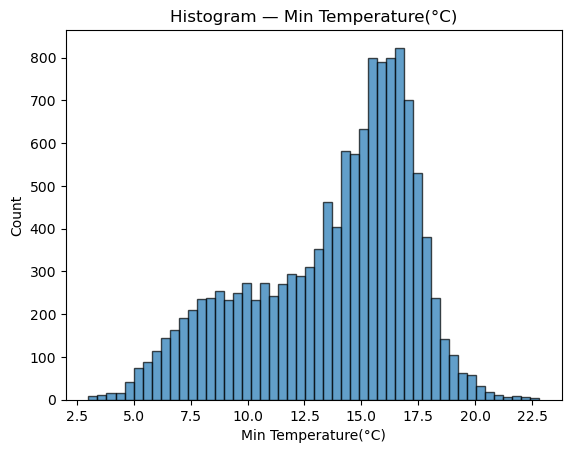

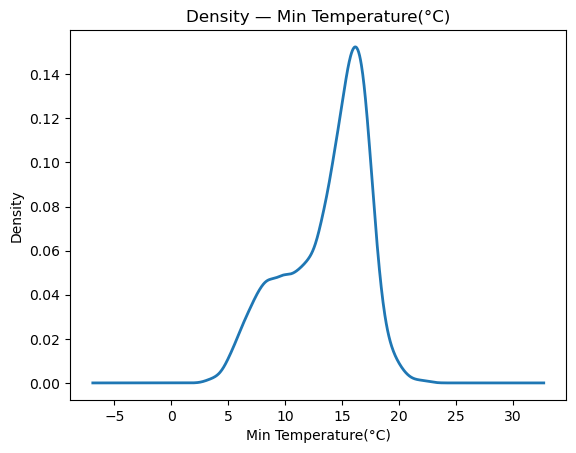

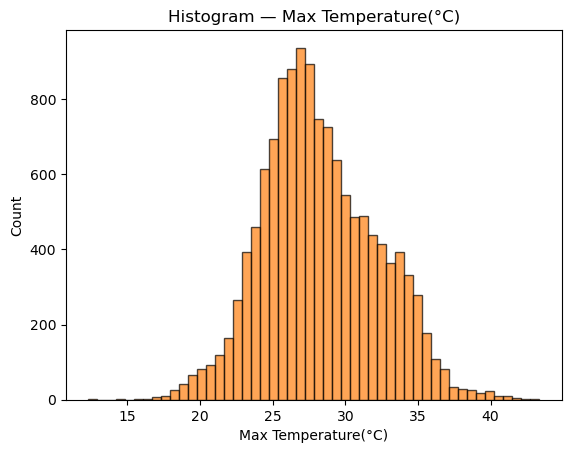

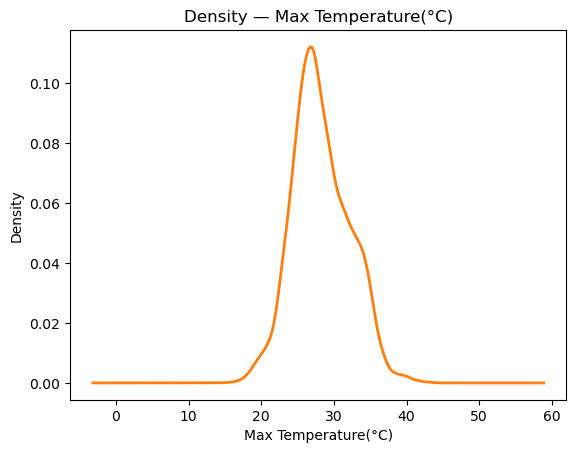

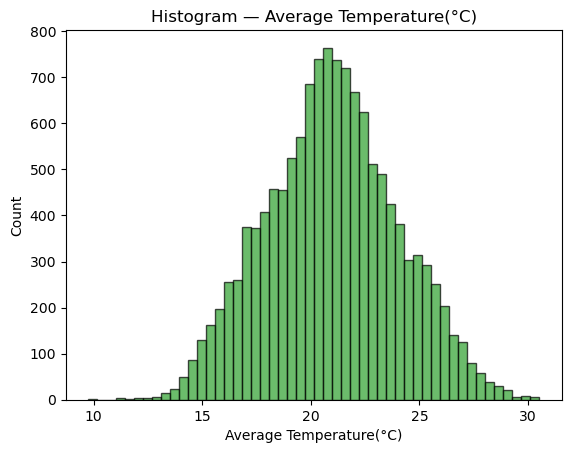

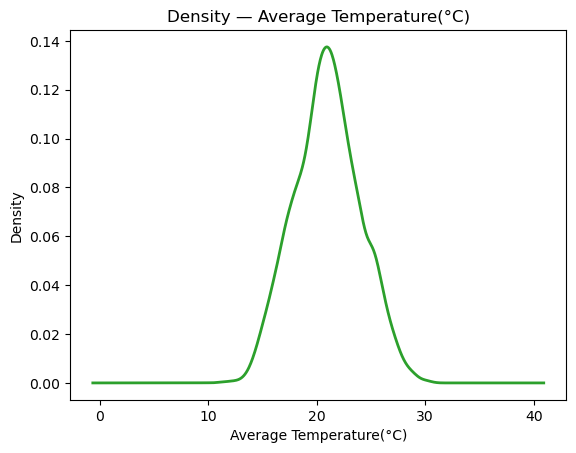

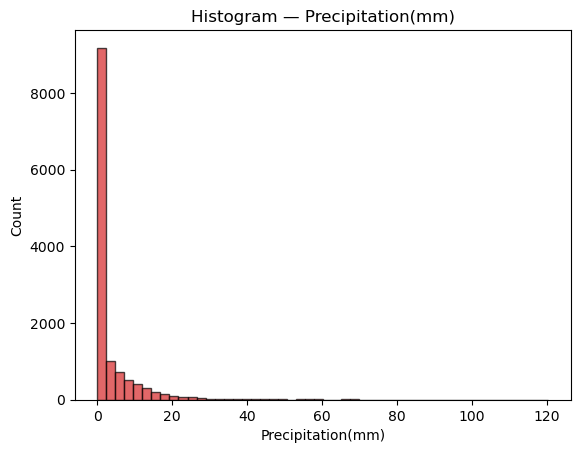

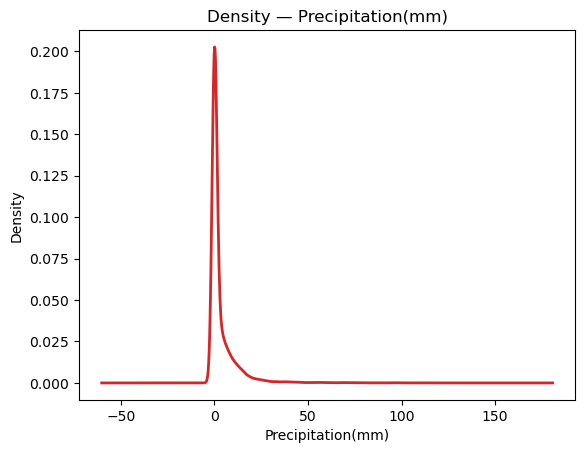

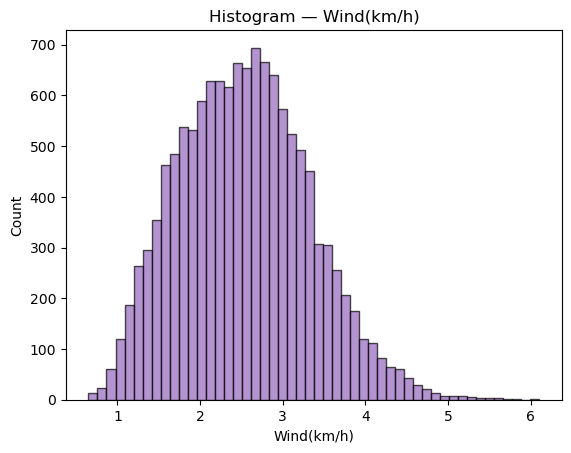

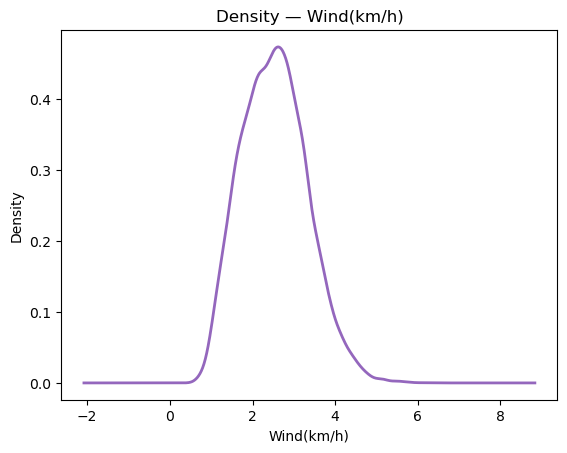

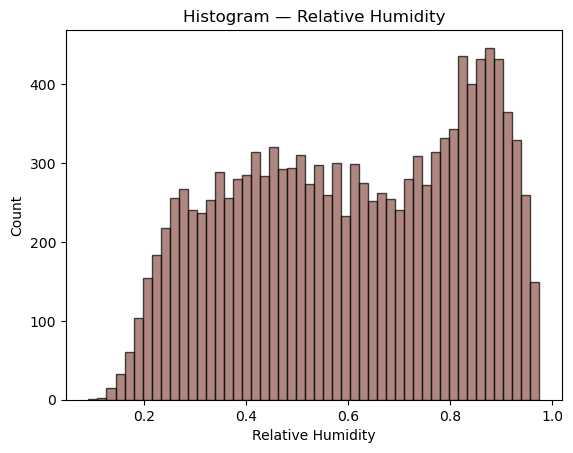

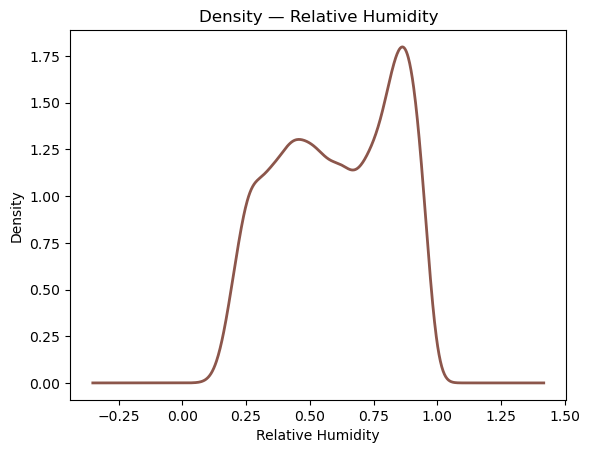

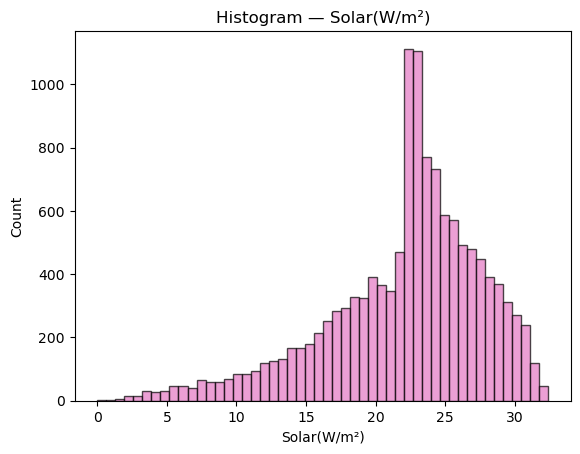

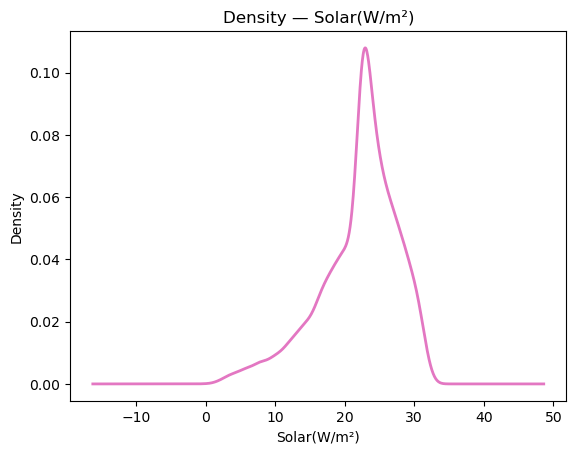

In [69]:
# Plotting Histograms and denstity plot to check if variables look normal or skewed
#Defining color maps so each predictor has its own color graph to distinguish from another predictor 
colors = plt.cm.tab10.colors
color_map={col:colors[i % len(colors)] for i , col in enumerate(NUM_COLS)}

for col in NUM_COLS:
    data = eda_df[col].dropna()
    
    c= color_map[col]

    # Histogram
    plt.figure()
    plt.hist(data, bins=50, alpha=0.7,color=c,edgecolor="black")   
    plt.title(f"Histogram — {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.show()

    # Density (KDE)
    plt.figure()
    data.plot(kind="density",color=c,linewidth=2)
    plt.title(f"Density — {col}")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.show()


The histograms above show the distribution of each weather variable, highlighting the spread, central tendency, and presence of skewness or outliers. The overlaid density plots provide a smooth view of the underlying distribution, making it easier to compare variable shapes. Together, these plots reveal that temperature variables follow relatively normal-like distributions, while features such as precipitation and wind show skewness with extreme values, which may influence model performance.

**BOX/ WHISKERS PLOTS OUTLIER DETECTION**

Here trying to check for dots far from the box/whiskers = potential extreme events (e.g., heavy rain days, heat spikes).

C:\Users\user\AppData\Local\Temp\ipykernel_19892\2048311636.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,


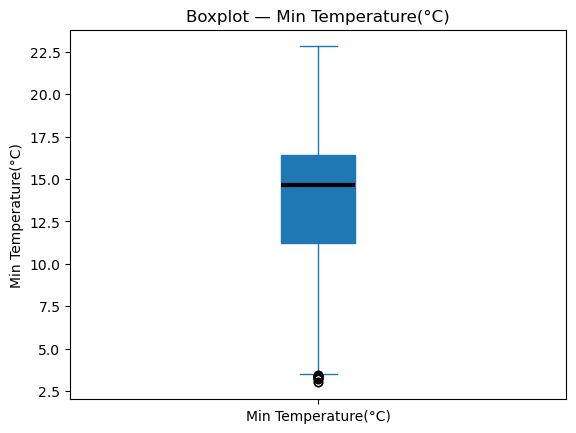

C:\Users\user\AppData\Local\Temp\ipykernel_19892\2048311636.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,


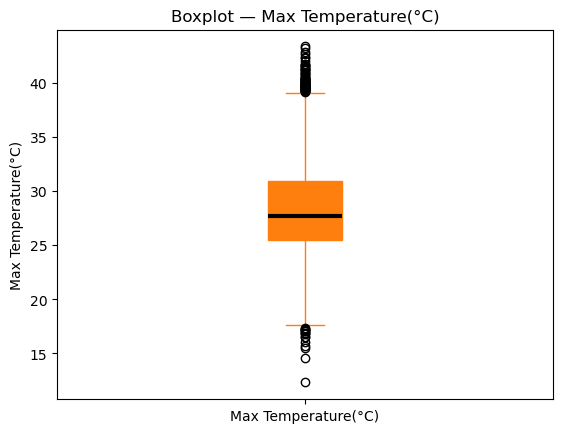

C:\Users\user\AppData\Local\Temp\ipykernel_19892\2048311636.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,


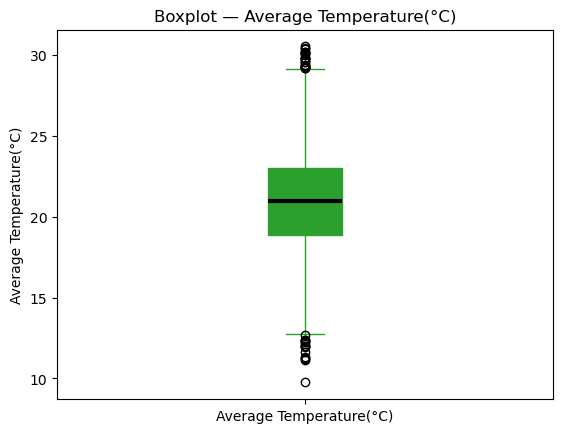

C:\Users\user\AppData\Local\Temp\ipykernel_19892\2048311636.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,


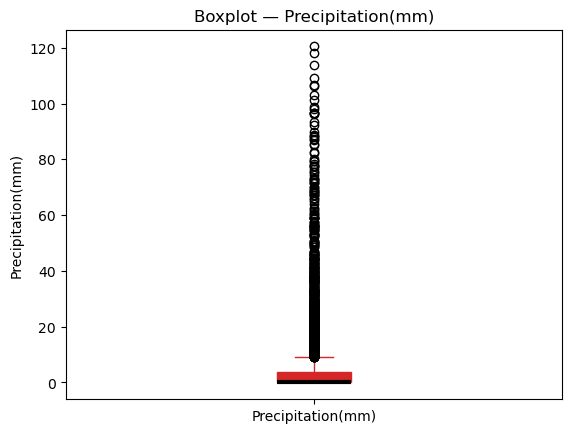

C:\Users\user\AppData\Local\Temp\ipykernel_19892\2048311636.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,


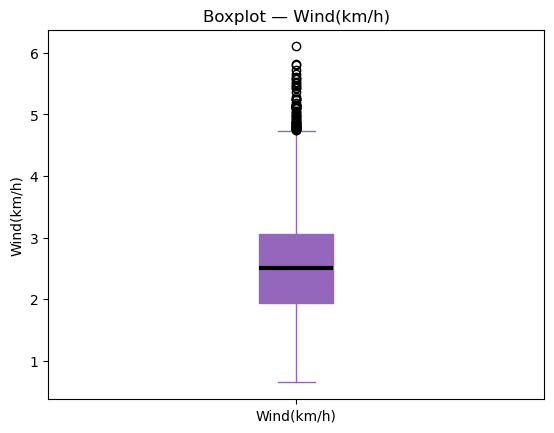

C:\Users\user\AppData\Local\Temp\ipykernel_19892\2048311636.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,


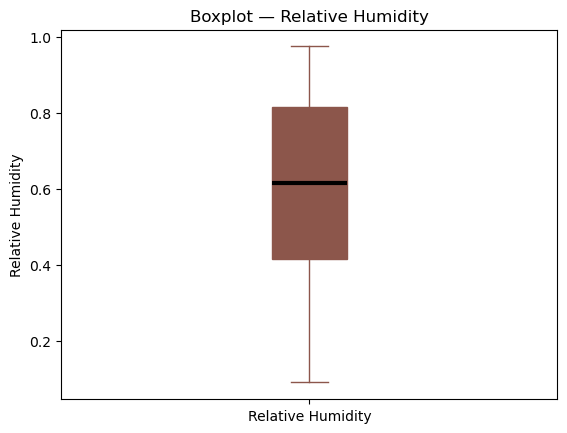

C:\Users\user\AppData\Local\Temp\ipykernel_19892\2048311636.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,


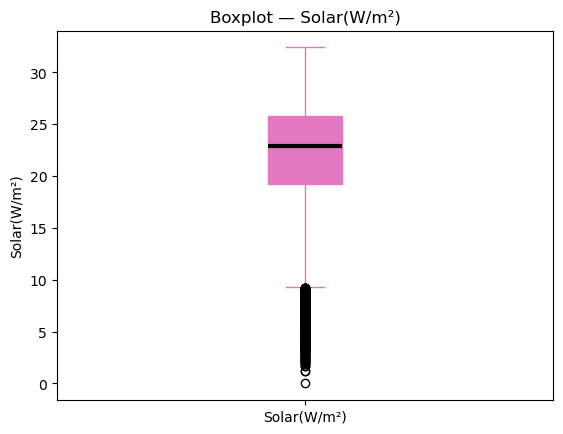

In [72]:

# Boxplots to Spot extreme (Outliers) values that might affect/ bias models.

# Defining the same color map as the above plots for consistancy 
colors = plt.cm.tab10.colors
color_map = {col: colors[i % len(colors)] for i, col in enumerate(NUM_COLS)}

# Boxplots
for col in NUM_COLS:
    data = eda_df[col].dropna().values
    # pick color for this column
    c = color_map[col]  

    plt.figure()
    plt.boxplot(data,vert=True,labels=[col],showfliers=True,patch_artist=True,
        # box fill + edge color
        boxprops=dict(facecolor=c, color=c),
        # median line in black
        medianprops=dict(color="black", linewidth=3),whiskerprops=dict(color=c),capprops=dict(color=c))
    plt.title(f"Boxplot — {col}")
    plt.ylabel(col)
    plt.show()



The boxplots above display the spread and outliers for each weather variable. Temperatures (min, max, and average) are mostly stable, with some extreme highs and lows at the tails. Precipitation is highly skewed, showing mostly low daily values but many extreme rainfall outliers. Wind and solar radiation also exhibit noticeable outliers, though within a moderate range, while relative humidity remains more balanced with fewer extremes. These patterns highlight where variables are consistent versus where rare extreme events may bias or influence forecasting models.

**TEMPORAL ANALYSIS**

Checking for temporal analysis to see if this reveals his reveals annual cycles (e.g., more rain in some months , more solar radiation in mid-year)

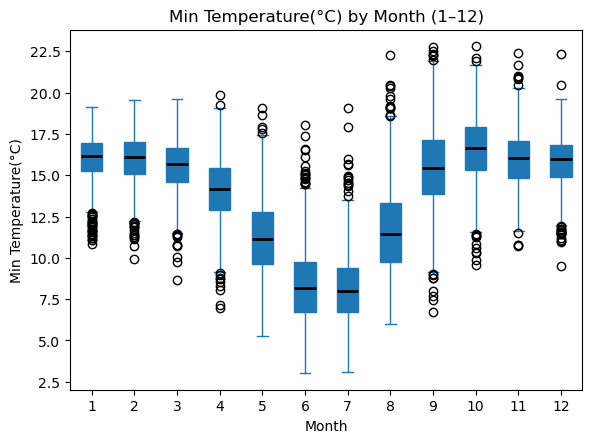

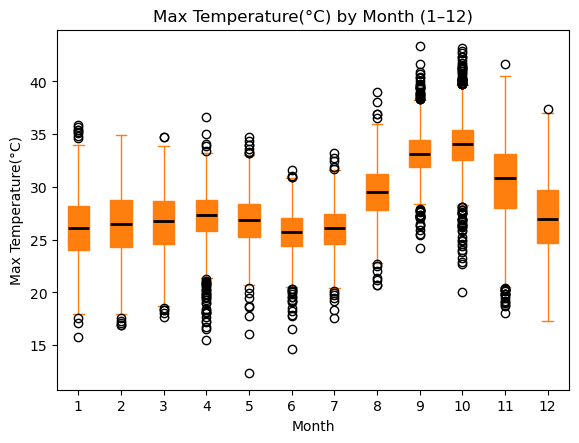

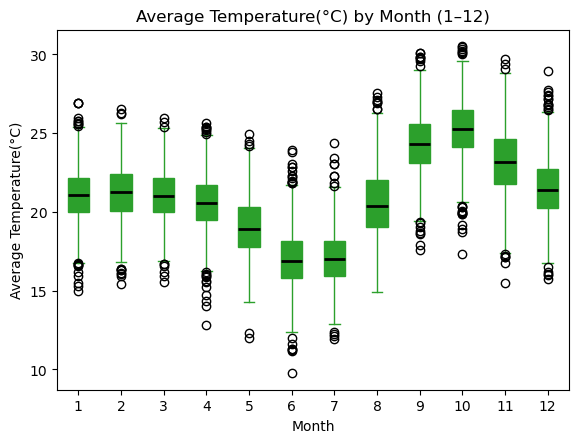

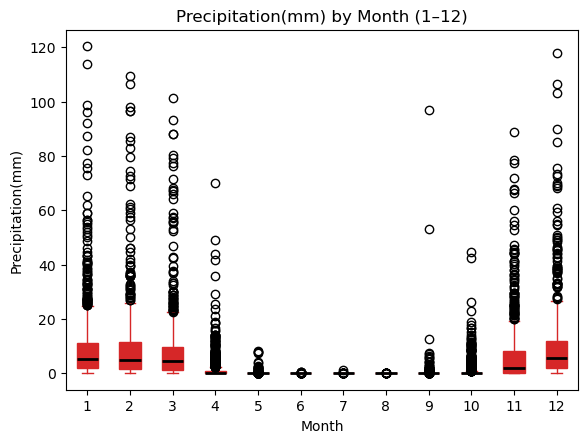

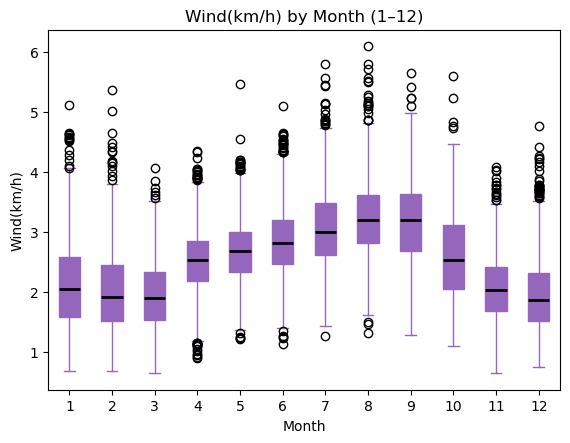

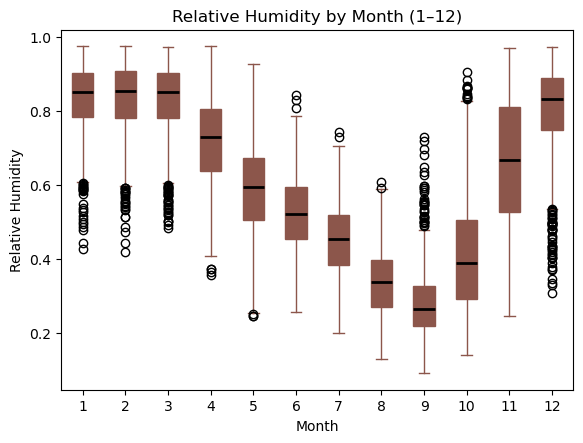

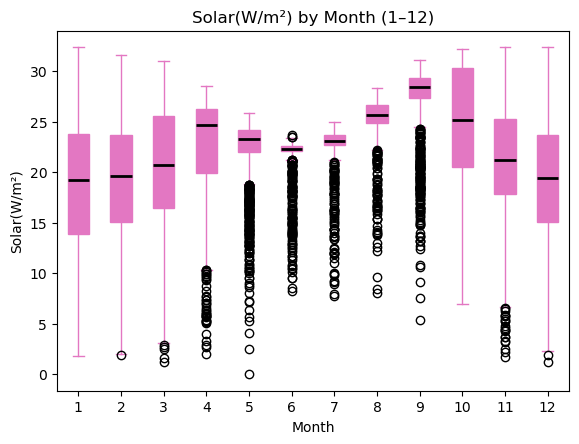

In [75]:

# Boxplots by month for each variable
if MONTH not in eda_df.columns:
    eda_df[MONTH] = eda_df["Date"].dt.month



# color palette
colors = plt.cm.tab10.colors
color_map = {col: colors[i % len(colors)] for i, col in enumerate(NUM_COLS)}

for col in NUM_COLS:
    eda_df.boxplot(
        column=col,
        by="Month",
        grid=False,
        patch_artist=True,   # allows filling with color
        boxprops=dict(facecolor=color_map[col], color=color_map[col]),
        whiskerprops=dict(color=color_map[col]),
        capprops=dict(color=color_map[col]),
        medianprops=dict(color="black", linewidth=2),
    )
    plt.title(f"{col} by Month (1–12)")
    plt.suptitle("")  
    plt.xlabel("Month")
    plt.ylabel(col)
    plt.show()




The monthly boxplots above highlight clear seasonal patterns across all weather variables. Minimum, maximum, and average temperatures follow expected cycles, dipping mid-year (June–July) and peaking toward December–January. Precipitation is highly skewed, with most months showing low rainfall but extreme outliers during the rainy season. Wind speeds remain relatively stable with moderate variation, while relative humidity and solar radiation exhibit opposite seasonal trends humidity is higher in the early months, whereas solar intensity peaks later in the year. These temporal patterns are important for capturing seasonality in forecasting models.




Extreme Events, defining extremes using quantiles (e.g., “top 1% of max temperature values”

In [78]:
# Choosing which variables to flag for extremes
# top 1% max temperatures
# top 1% precipitation
# top 1% wind
extreme_values = {
    MAX_TEMP:0.99,   
    MIN_TEMP:0.99,
    PRECIP:0.99,   
    WIND:0.99,}   

# Creating the flags
for col, i in extreme_values.items():
    thresh = eda_df[col].quantile(i)
    flag_col = f"Extreme_Days_{col}"
    eda_df[flag_col] = eda_df[col] > thresh
    print(f"{col}: threshold for top {int((1-i)*100)}% = {thresh:.3f}")

# Counting the number of days there was extreme events in the data set 
flag_cols = [c for c in eda_df.columns if c.startswith("Extreme_Days_")]
extreme_counts = eda_df[flag_cols].sum().sort_values(ascending=False)
print("\nNumber of days Extreme events occured :")
print(extreme_counts)


Max Temperature(°C): threshold for top 1% = 37.680
Min Temperature(°C): threshold for top 1% = 19.705
Precipitation(mm): threshold for top 1% = 43.249
Wind(km/h): threshold for top 1% = 4.519

Number of days Extreme events occured :
Extreme_Days_Max Temperature(°C)    130
Extreme_Days_Min Temperature(°C)    130
Extreme_Days_Precipitation(mm)      130
Extreme_Days_Wind(km/h)             130
dtype: int64


## 3. Time Series and Seasonal Patterns  

#### Hypotheses / Questions:

5. Do temperatures and other climate variables show clear seasonal patterns over the years?
6. Are there long-term trends in warming, cooling, or rainfall changes that emerge when comparing across decades?

#### Why it’s beneficial
Weather data is inherently temporal and seasonal. Distribution analysis reveals cycles (daily, monthly, yearly) and long-term trends. Rolling averages help detect climate change signals or data drift.
#### What we’re looking for
Autocorrelation – strong autocorrelation means past values are highly predictive of future ones.
Seasonal peaks – clear yearly or monthly cycles indicate seasonal features must be included.
Trend slopes – upward temperature trend shows stationarity is violated; linear regression without detrending may fail.
#### Impact on model choice
**General models:** Linear regression may work if lagged variables (e.g., yesterday’s temperature, last week’s average) and explicit seasonal terms are added, but it struggles when stationarity is violated. Time-series models such as ARIMA or LSTM are better suited for autocorrelated, seasonal data since they directly account for temporal dependencies. **Tree-based models** (Random Forest, Gradient Boosting) can also capture non-linear seasonality and long-term shifts without needing strict assumptions, making them more robust than plain regression for weather forecasting.

**Time series Decomposition**

Time series decomposition separates a dataset into seasonality, trend, and residuals. Seasonality captures repeating yearly cycles, trends show long-term increases or decreases, and residuals represent random noise that cannot be explained by either. This breakdown helps reveal both predictable patterns and unpredictable fluctuations in the data.

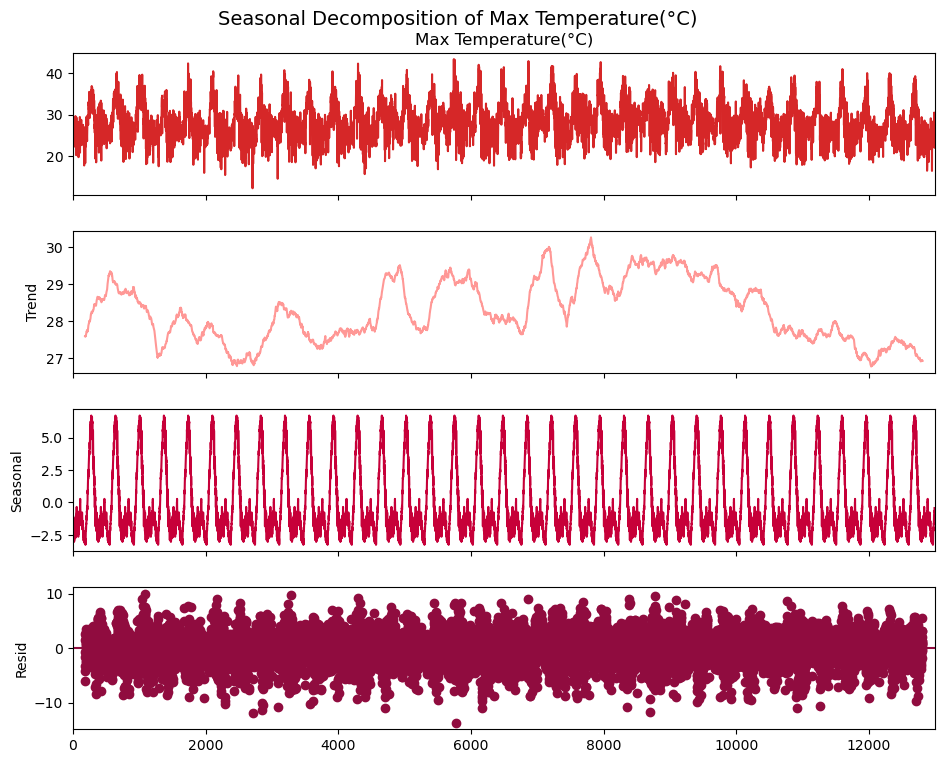

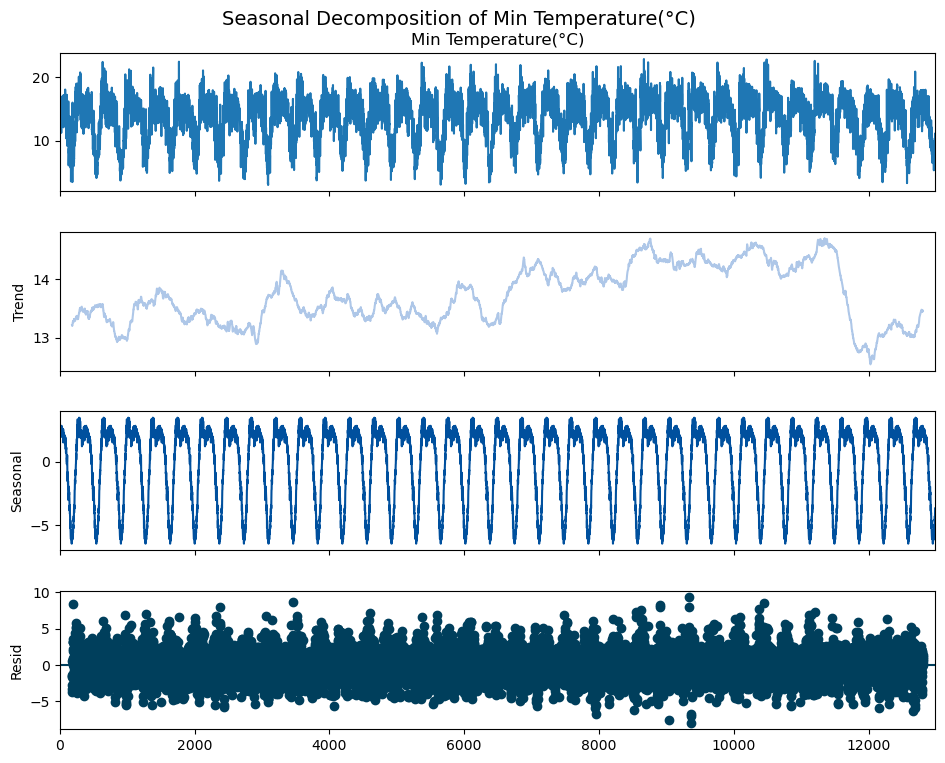

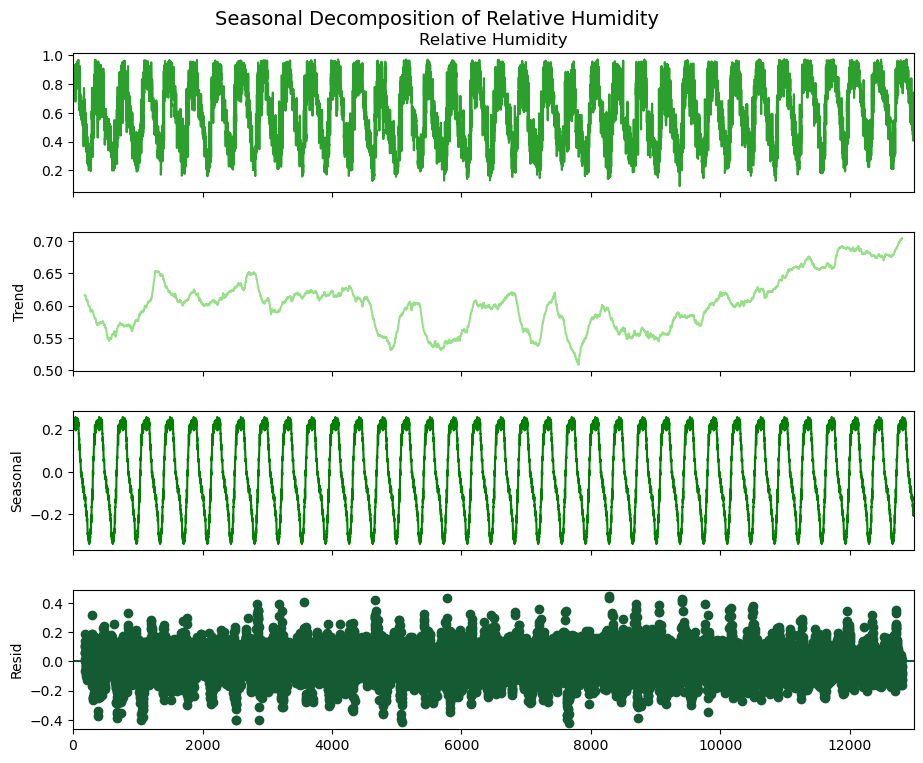

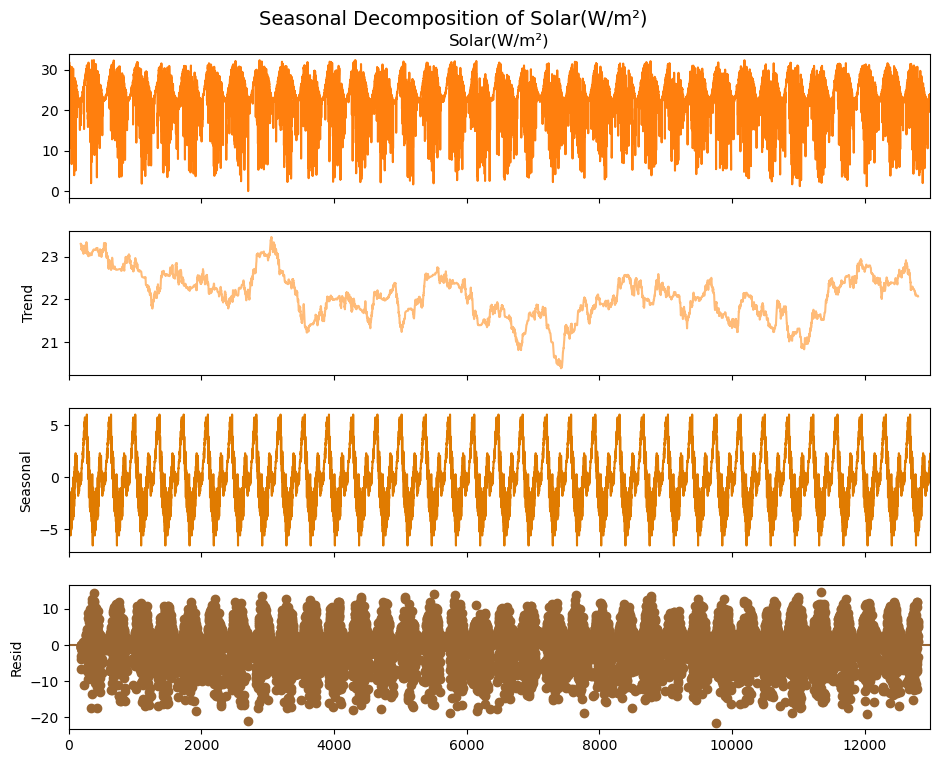

In [83]:
#This block of code performs seasonal decomposition for each selected variable (e.g., temperature, humidity, solar).
#The series is broken into trend, seasonal, and residual components using an additive model, with a period of 365 days to capture yearly cycles. 
#This helps to separate long-term trends from repeating seasonal effects and irregular noise.

# Variables worth decomposing
vars_to_decompose = [
    'Max Temperature(°C)',
    'Min Temperature(°C)',
    'Relative Humidity',
    'Solar(W/m²)'
]

# Defining custom colors (pick 4 sets for variety per variable)
color_sets = {
    'Max Temperature(°C)': ['#d62728', '#ff9896', '#c70039', '#900c3f'],  
    'Min Temperature(°C)': ['#1f77b4', '#aec7e8', '#00509e', '#003f5c'],  
    'Relative Humidity':   ['#2ca02c', '#98df8a', '#008000', '#145a32'],  
    'Solar(W/m²)':         ['#ff7f0e', '#ffbb78', '#e07b00', '#996633']   
}

for col in vars_to_decompose:
    result = seasonal_decompose(eda_df[col], model='additive', period=365)

    fig = result.plot()
    fig.set_size_inches(10, 8)
    
    # Apply custom colors
    axes = fig.get_axes()
    for ax, color in zip(axes, color_sets[col]):
        for line in ax.get_lines():
            line.set_color(color)

    plt.suptitle(f"Seasonal Decomposition of {col}", fontsize=14)
    plt.show()




**Autocorrelation** 

Autocorrelation describes how the current value of a time series relates to its past values. It helps identify whether patterns repeat over time, which is critical for forecasting.

Positive autocorrelation: High values are followed by other high values, and low values by low values.

Negative autocorrelation: High values are followed by low values, and vice versa.

To detect autocorrelation, two main tools are used:

Autocorrelation Function (ACF) plot – shows correlations across many time lags.
Partial Autocorrelation Function (PACF) plot – shows the direct effect of specific lags after removing intermediate ones.

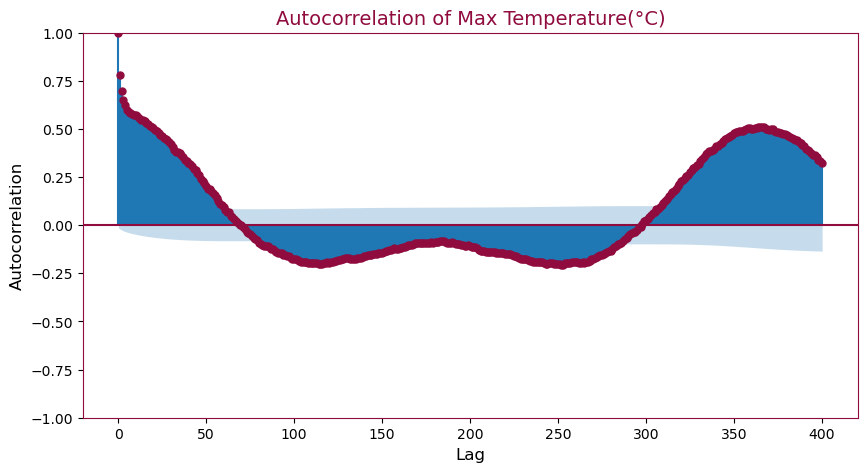

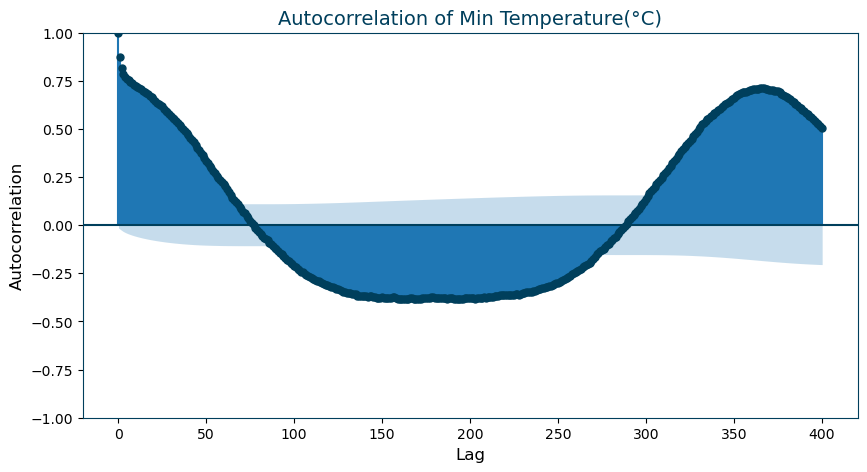

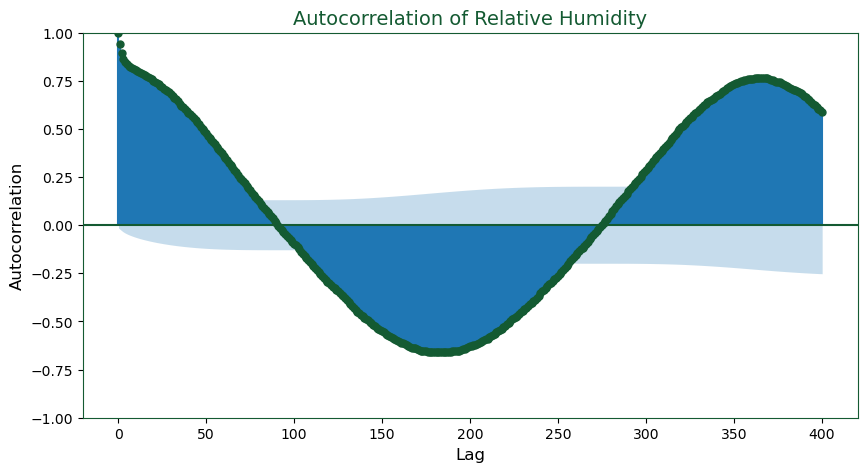

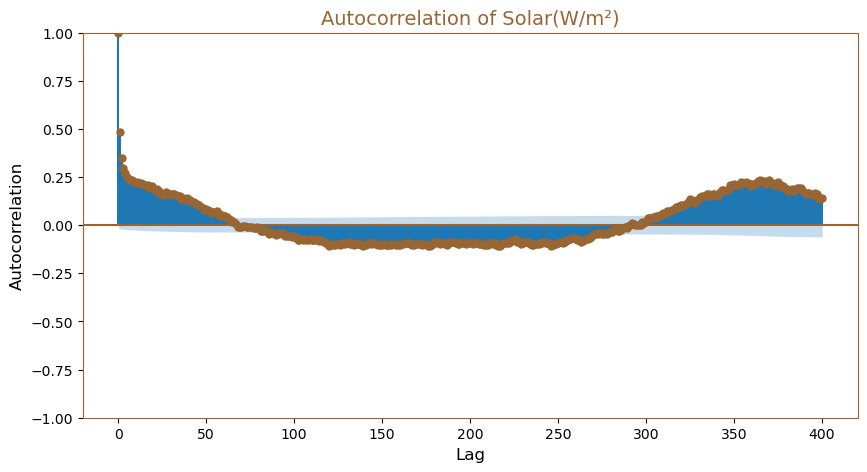

In [85]:
#This block of code generates Autocorrelation Function (ACF) plots for each variable, 
#showing how current values are correlated with past values across up to 400 lags (just over one year for daily data). 
#ACF helps detect seasonality, persistence, and repeating patterns in the dataset, which are important for forecasting.

# Variables to check
vars_to_check = [
    'Max Temperature(°C)',
    'Min Temperature(°C)',
    'Relative Humidity',
    'Solar(W/m²)'
]

# Assigning distinct colors for each variable
colors = {
    'Max Temperature(°C)': '#900c3f',
    'Min Temperature(°C)': '#003f5c',
    'Relative Humidity': '#145a32',
    'Solar(W/m²)': '#996633'
}

for col in vars_to_check:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_acf(eda_df[col], lags=400, ax=ax, color=colors[col])  
    
    # Title and styling
    plt.title(f"Autocorrelation of {col}", fontsize=14, color=colors[col])
    ax.set_xlabel("Lag", fontsize=12)
    ax.set_ylabel("Autocorrelation", fontsize=12)
    ax.spines['top'].set_color(colors[col])
    ax.spines['right'].set_color(colors[col])
    ax.spines['left'].set_color(colors[col])
    ax.spines['bottom'].set_color(colors[col])
    plt.show()


The autocorrelation plots for maximum temperature, minimum temperature, relative humidity, and solar radiation all show strong positive correlations at short lags, which gradually decay as the lag increases. This indicates that weather conditions on a given day are closely related to conditions on recent days. In addition, clear peaks reappear around lag ~365, confirming the presence of a strong annual seasonal cycle across these variables. The similarity in patterns for temperature, humidity, and solar radiation highlights that they share common seasonal drivers such as annual climatic cycles. These findings support the hypothesis that weather variables follow long-term seasonal trends and justify the inclusion of temporal features in the modelling stage.

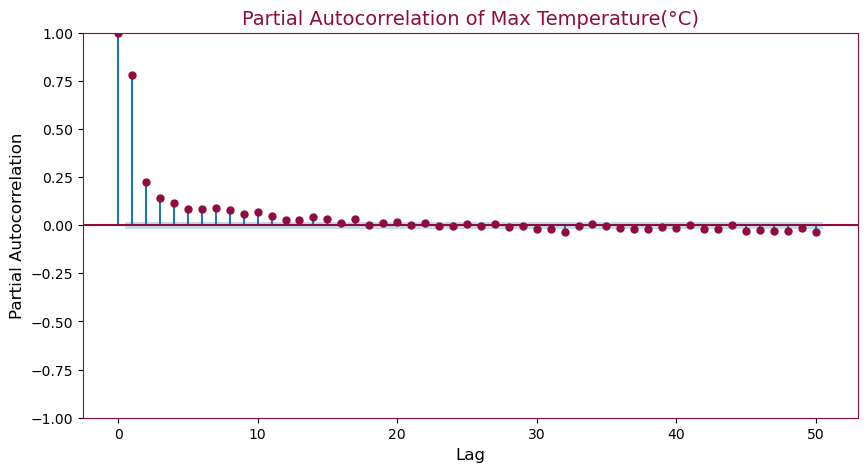

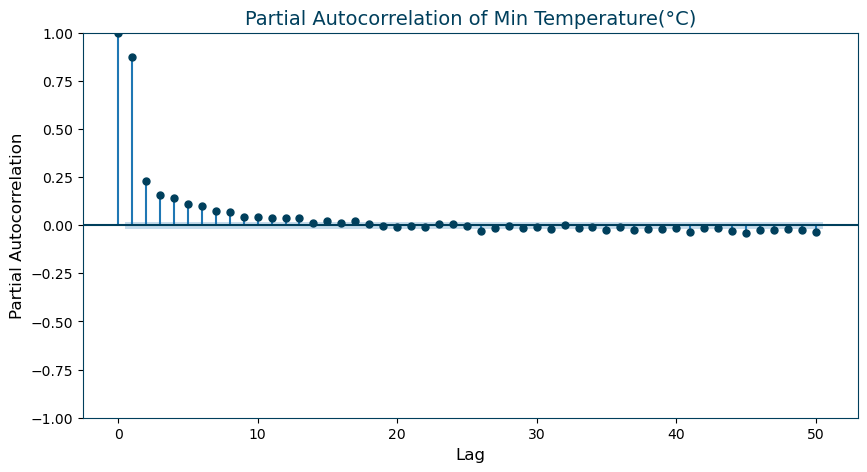

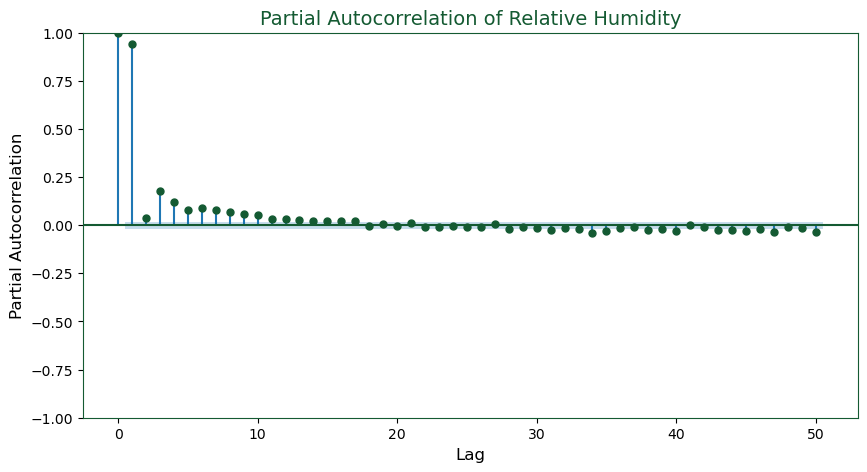

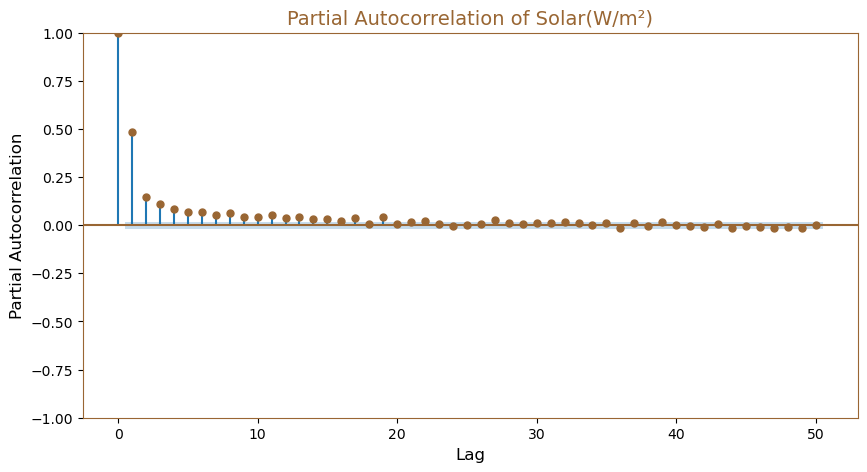

In [87]:
#This block of code produces Partial Autocorrelation Function (PACF) plots for each variable,
#focusing on the direct influence of specific lags (up to 50). 
#Unlike ACF, PACF removes the indirect effects of shorter lags, 
#making it clearer which recent past values directly affect the present. 
#This is useful for understanding short-term dependencies in weather variables.

# Variables to check

vars_to_check = [
    'Max Temperature(°C)',
    'Min Temperature(°C)',
    'Relative Humidity',
    'Solar(W/m²)'
]

# Assigning distinct colors for each variable
colors = {
    'Max Temperature(°C)': '#900c3f',
    'Min Temperature(°C)': '#003f5c',
    'Relative Humidity': '#145a32',
    'Solar(W/m²)': '#996633'
}

for col in vars_to_check:
    fig, ax = plt.subplots(figsize=(10,5))
    plot_pacf(eda_df[col], lags=50, ax=ax, color=colors[col])  
    
    # Title and styling
    plt.title(f"Partial Autocorrelation of {col}", fontsize=14, color=colors[col])
    ax.set_xlabel("Lag", fontsize=12)
    ax.set_ylabel("Partial Autocorrelation", fontsize=12)
    ax.spines['top'].set_color(colors[col])
    ax.spines['right'].set_color(colors[col])
    ax.spines['left'].set_color(colors[col])
    ax.spines['bottom'].set_color(colors[col])
    plt.show()


The partial autocorrelation plots show strong spikes at lag 1 for all variables, indicating that the immediate past day has the greatest direct influence on current values. Smaller but still visible correlations extend to short lags (up to around 5–7 days), suggesting short-term persistence in weather conditions. Beyond these lags, the PACF values drop close to zero, meaning that longer-term correlations are largely explained by the seasonal cycles already captured in the ACF. Together, the PACF results confirm that weather variables are strongly influenced by their most recent past values, while broader seasonal effects appear indirectly through repeated yearly cycles. This supports the inclusion of both short-term lagged features and longer-term seasonal indicators in the modelling stage.

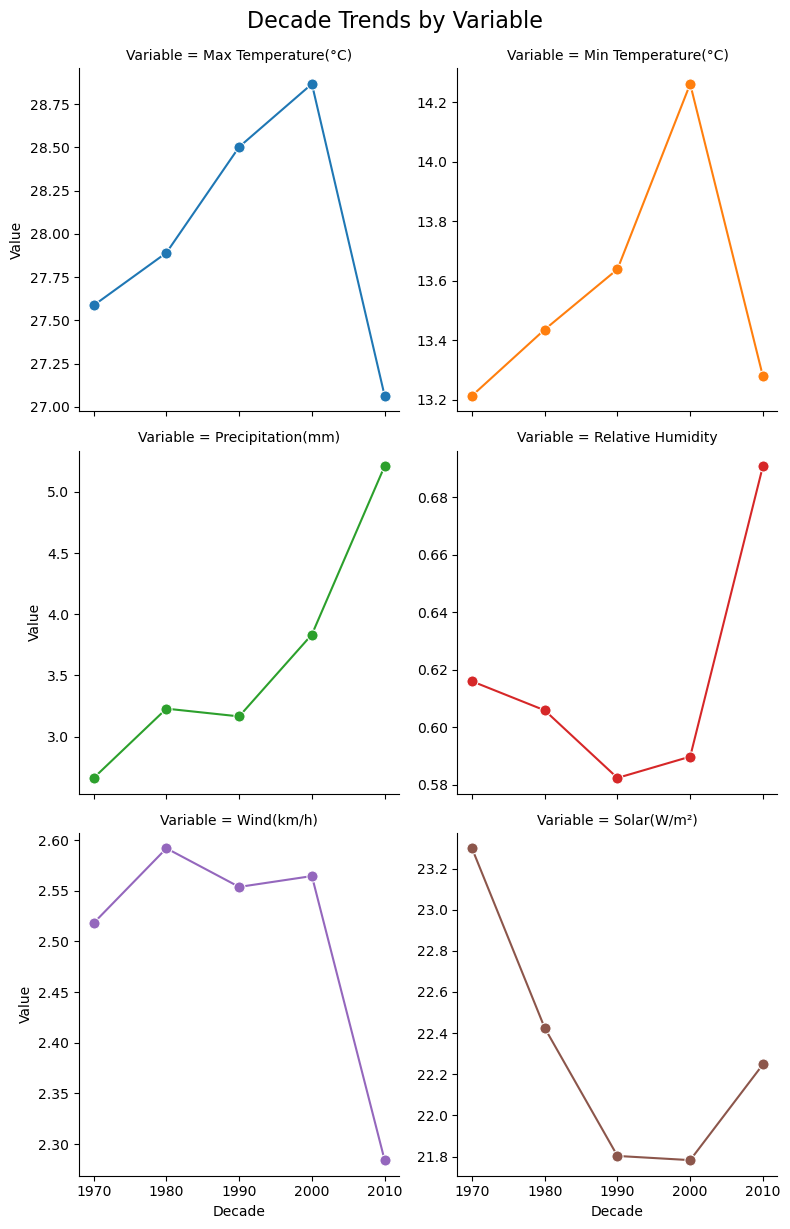

In [89]:
# Trend comparison across decades

# selecting the columns needed 
# keeping only columns that exist
# checking if values are numeric
# then create a decade key
cols = ['Max Temperature(°C)','Min Temperature(°C)','Precipitation(mm)',
        'Relative Humidity','Wind(km/h)','Solar(W/m²)']
cols = [c for c in cols if c in eda_df.columns]                 
eda_df[cols] = eda_df[cols].apply(pd.to_numeric, errors='coerce')   
eda_df['Decade'] = (eda_df['Year'] // 10) * 10                      

# decade averages -> long form for faceting
decade_avg  = eda_df.groupby('Decade')[cols].mean(numeric_only=True)
decade_long = decade_avg.reset_index().melt(
    id_vars='Decade', var_name='Variable', value_name='Value'
).dropna(subset=['Value'])

# Removing FutureWarning from seaborn/pandas about use_inf_as_na
warnings.filterwarnings("ignore", message=".*use_inf_as_na.*", category=FutureWarning)

# Melting data for facet plotting
decade_long = decade_avg.reset_index().melt(id_vars="Decade", var_name="Variable", value_name="Value")

# Define color palette (one color per variable)
palette = dict(zip(cols,
    sns.color_palette("tab10", n_colors=len(cols))  # tab10 gives distinct colors
))

# Facet plot with custom colors
plot = sns.FacetGrid(
    decade_long,
    col="Variable",
    col_wrap=2,
    sharey=False,
    height=4
)

# Map lineplot and use palette by variable
plot.map_dataframe(
    sns.lineplot,
    x="Decade",
    y="Value",
    hue="Variable",
    marker="o",
    markersize=8,
    palette=palette,
    legend=False
)

plot.fig.suptitle("Decade Trends by Variable", fontsize=16, y=1.02)
plt.show()



Overall, the temporal analysis demonstrates that the dataset contains both short-term persistence and long-term seasonality, reinforced by clear decade-level variability. These insights support the hypothesis that weather patterns are influenced by recent past values, seasonal cycles, and gradual climate shifts. For modelling, this confirms the need for approaches that can capture complex temporal dependencies and interactions, such as Random Forests, which are capable of leveraging both lagged predictors and non-linear seasonal effects.

## 4. Correlation relationship and Analysis 

#### Hypotheses / Questions:

7. Is temperature strongly correlated with solar radiation and humidity?
8. Do wind and precipitation add predictive power or are they weakly related?

#### Why it’s beneficial
Shows how predictors interact with temperature (the target). Identifies multicollinearity (predictors too correlated with each other). Helps prioritize which variables should go into the model.
#### What we’re looking for
Correlation with target (Max Temp/Min Temp): High correlation (e.g., solar vs Max Temp = 0.7)  strong predictor. Low correlation (e.g., wind vs Max Temp = 0.1)  may not add much value.
Multicollinearity among predictors: If two predictors are highly correlated (e.g., humidity vs precipitation, r > 0.85), one may be redundant.
Partial correlations: Example: humidity negatively correlated with Max Temp, even when solar is controlled.
#### Impact on model choice
**Tree-based models** (Random Forest, XGBoost) handle multicollinearity better by automatically choosing dominant splits and down-weighting redundant predictors. Neural networks can capture nonlinear interactions (e.g., Max Temp rising with solar only when humidity is low), but require larger datasets to generalize well.
**General models:** Linear RegressionAssumes low multicollinearity. High collinearity inflates coefficients and produces unstable results (VIF > 10 = problematic). Strong predictor–target correlations mean regression could perform well, but redundancy must be managed.


In [94]:
#Computing Correlation Matrices
#Checking both Pearson (linear relationships) and Spearman (monotonic relationships, more robust to non-linearity).



# Numeric columns of interest
numeric_cols = ['Min Temperature(°C)', 'Max Temperature(°C)', 'Average Temperature(°C)', 
                'Precipitation(mm)', 'Wind(km/h)', 'Relative Humidity', 'Solar(W/m²)']

# Computing correlations
pearson_corr = eda_df[numeric_cols].corr(method='pearson')
spearman_corr = eda_df[numeric_cols].corr(method='spearman')

# Converting to DataFrames for better visualization
pearson_df = pd.DataFrame(pearson_corr)
spearman_df = pd.DataFrame(spearman_corr)

# Displaying them side by side 

print("Pearson Correlation Matrix")
display(pearson_df)

print(" Spearman Correlation Matrix")
display(spearman_df)



Pearson Correlation Matrix


Min Temperature(°C)  Max Temperature(°C)  \
Min Temperature(°C)                    1.000                0.314   
Max Temperature(°C)                    0.314                1.000   
Average Temperature(°C)                0.788                0.832   
Precipitation(mm)                      0.290               -0.318   
Wind(km/h)                            -0.239                0.028   
Relative Humidity                      0.288               -0.608   
Solar(W/m²)                           -0.167                0.512   

                         Average Temperature(°C)  Precipitation(mm)  \
Min Temperature(°C)                        0.788              0.290   
Max Temperature(°C)                        0.832             -0.318   
Average Temperature(°C)                    1.000             -0.037   
Precipitation(mm)                         -0.037              1.000   
Wind(km/h)                                -0.122             -0.350   
Relative Humidity                         -0.226              0.497   
Solar(W/m²)                                0.235             -0.389   

                         Wind(km/h)  Relative Humidity  Solar(W/m²)  
Min Temperature(°C)          -0.239              0.288       -0.167  
Max Temperature(°C)           0.028             -0.608        0.512  
Average Temperature(°C)      -0.122             -0.226        0.235  
Precipitation(mm)            -0.350              0.497       -0.389  
Wind(km/h)                    1.000             -0.565        0.314  
Relative Humidity            -0.565              1.000       -0.550  
Solar(W/m²)                   0.314             -0.550        1.000

 Spearman Correlation Matrix


Min Temperature(°C)  Max Temperature(°C)  \
Min Temperature(°C)                    1.000                0.274   
Max Temperature(°C)                    0.274                1.000   
Average Temperature(°C)                0.738                0.826   
Precipitation(mm)                      0.543               -0.299   
Wind(km/h)                            -0.249                0.041   
Relative Humidity                      0.298               -0.609   
Solar(W/m²)                           -0.157                0.454   

                         Average Temperature(°C)  Precipitation(mm)  \
Min Temperature(°C)                        0.738              0.543   
Max Temperature(°C)                        0.826             -0.299   
Average Temperature(°C)                    1.000              0.124   
Precipitation(mm)                          0.124              1.000   
Wind(km/h)                                -0.124             -0.605   
Relative Humidity                         -0.215              0.833   
Solar(W/m²)                                0.232             -0.427   

                         Wind(km/h)  Relative Humidity  Solar(W/m²)  
Min Temperature(°C)          -0.249              0.298       -0.157  
Max Temperature(°C)           0.041             -0.609        0.454  
Average Temperature(°C)      -0.124             -0.215        0.232  
Precipitation(mm)            -0.605              0.833       -0.427  
Wind(km/h)                    1.000             -0.585        0.333  
Relative Humidity            -0.585              1.000       -0.534  
Solar(W/m²)                   0.333             -0.534        1.000

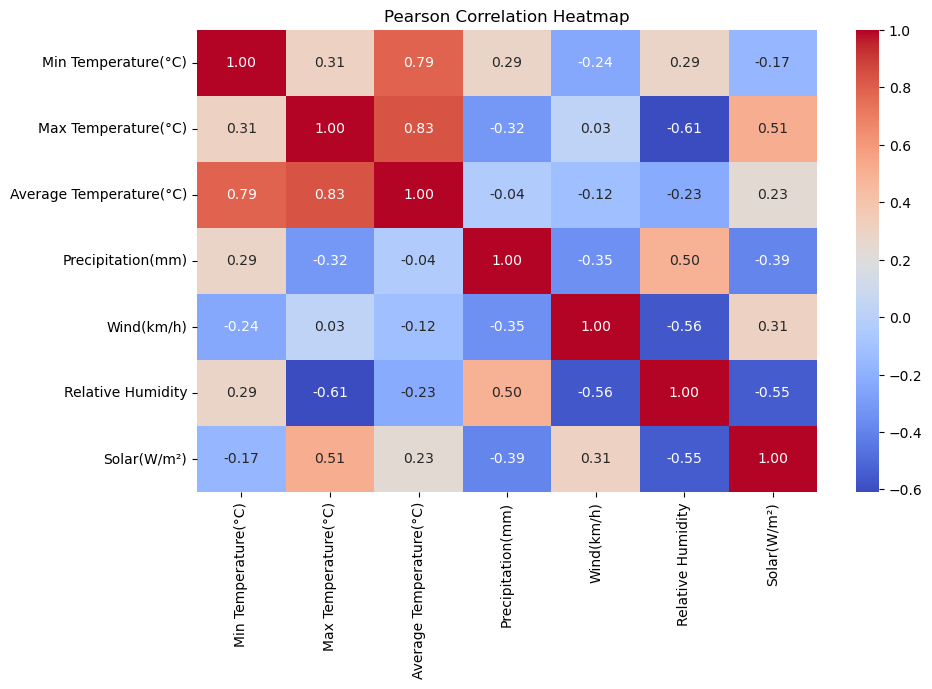

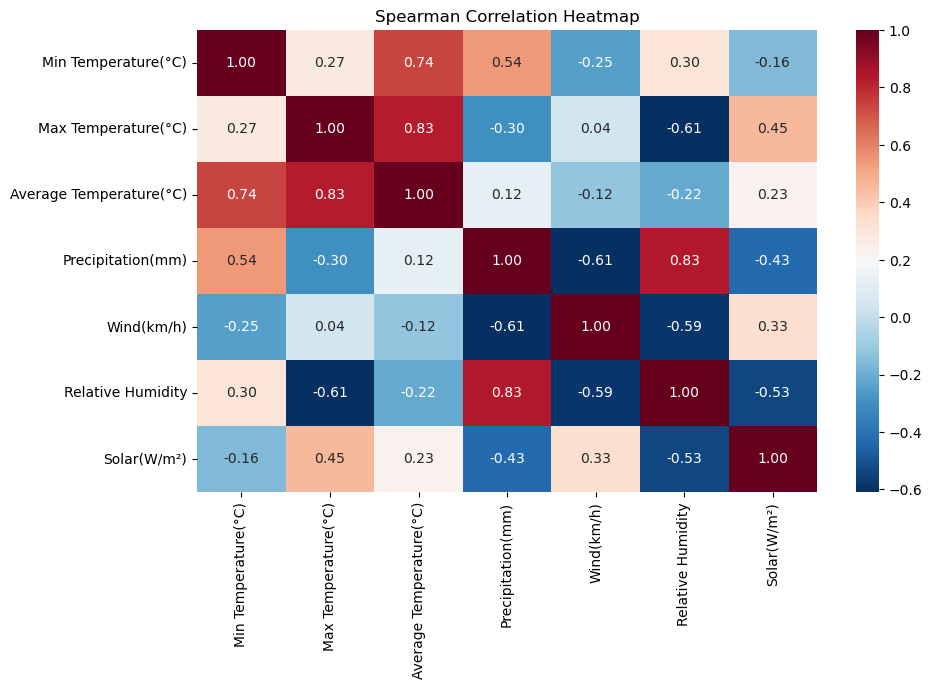

In [95]:
# Visualizing the relationship between variables 


# Pearson Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(pearson_corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pearson Correlation Heatmap")
plt.show()

# Spearman Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(spearman_corr, annot=True, cmap="RdBu_r", fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()


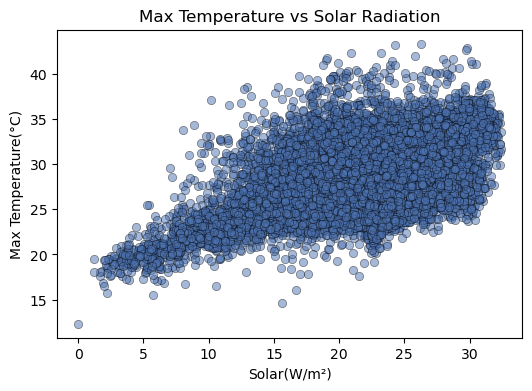

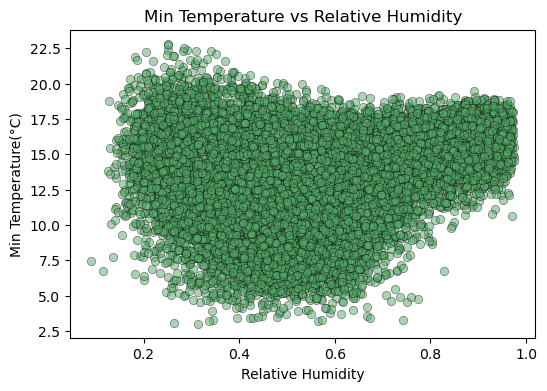

In [96]:
#Scatterplots for Hypothesis Testing
#Max Temp vs. Solar
#Min Temp vs. Humidity

# Scatterplot Max Temp vs Solar
plt.figure(figsize=(6,4))
sns.scatterplot(x='Solar(W/m²)', y='Max Temperature(°C)', data=eda_df,color=sns.color_palette("deep")[0], alpha=0.5, edgecolor="black")
plt.title("Max Temperature vs Solar Radiation")
plt.show()

# Scatterplot Min Temp vs Humidity
plt.figure(figsize=(6,4))
sns.scatterplot(x='Relative Humidity', y='Min Temperature(°C)', data=eda_df,color=sns.color_palette("deep")[2], alpha=0.5, edgecolor="black")
plt.title("Min Temperature vs Relative Humidity")
plt.show()


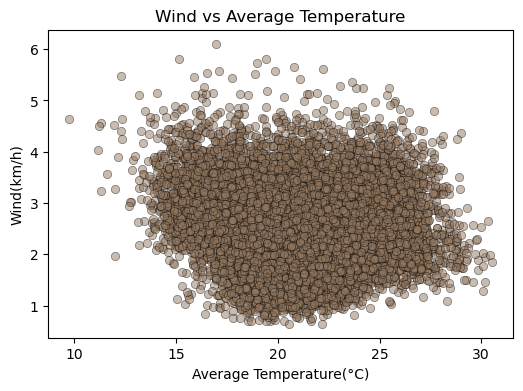

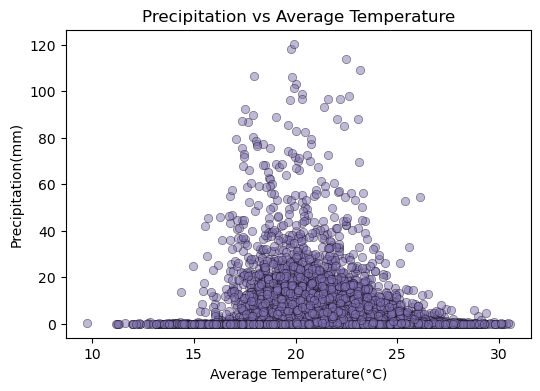

In [97]:
# Scatterplot Wind vs Avg Temp
plt.figure(figsize=(6,4))
sns.scatterplot(x='Average Temperature(°C)',y='Wind(km/h)', data=eda_df, color=sns.color_palette("deep")[5], alpha=0.5, edgecolor="black")
plt.title("Wind vs Average Temperature")
plt.show()

# Scatterplot Precipitation vs Avg Temp
plt.figure(figsize=(6,4))
sns.scatterplot(x='Average Temperature(°C)',y='Precipitation(mm)', data=eda_df, color=sns.color_palette("deep")[4], alpha=0.5, edgecolor="black")
plt.title("Precipitation vs Average Temperature")
plt.show()


**CORRELATION ANALYSIS:** 

The Pearson and Spearman heatmaps both reveal strong positive correlations between solar radiation and maximum temperature, confirming that higher solar intensity drives higher daytime temperatures. This is further illustrated in the scatterplot of Max Temperature vs Solar Radiation, which shows a clear upward trend. Similarly, minimum temperature shows a moderate negative relationship with relative humidity, reflected in the scatterplot where higher humidity is associated with slightly lower minimum temperatures. Wind speed and average temperature display a weak relationship, though some outliers suggest occasional spikes in wind under moderate temperatures. Precipitation shows little consistent correlation with average temperature, as most values cluster near zero but with extreme rainfall events acting as outliers. Overall, the combined heatmaps and scatterplots confirm that solar radiation and humidity are the most influential predictors for temperature, while wind and precipitation have weaker, less stable relationships.


# Preprocessing 

Outlier Handling + Normalization

Outlier Handling with IQR Clipping

The IQRClipper transformer calculates the interquartile range (IQR) for each feature and sets lower/upper bounds at 1.5 × IQR below Q1 and above Q3.

Any values outside this range are clipped (not removed) to the boundary.

This ensures extreme outliers do not distort the scale of features, while still retaining all observations.

After clipping, features are normalized using MinMaxScaler

In [101]:
for df in df_list:
    df = df.dropna()
    df = df.drop_duplicates()

In [102]:
for df in df_list:
    df['Date'] = pd.to_datetime(df['Date'])

    df["Year"] = df["Date"].dt.year  
    df["Month"] = df["Date"].dt.month 

In [103]:
df_list[0].columns

Index(['Date', 'Longitude', 'Latitude', 'Elevation', 'Max Temperature',
       'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity',
       'Solar', 'Year', 'Month'],
      dtype='object')

In [104]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# IQR Clipper for handling outliers
class IQRClipper(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.bounds_ = {}

    def fit(self, X, y=None):
        # Ensure X is a DataFrame
        df = pd.DataFrame(X, columns=self.cols) if not isinstance(X, pd.DataFrame) else X
        
        for col in self.cols:
            q1, q3 = df[col].quantile([0.25, 0.75])
            iqr = q3 - q1
            # Store bounds for each column
            self.bounds_[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
        return self

    def transform(self, X):
        # Ensure X is a DataFrame
        df = pd.DataFrame(X, columns=self.cols) if not isinstance(X, pd.DataFrame) else X.copy()
        
        for col, (lower, upper) in self.bounds_.items():
            # Clip values to the bounds
            df[col] = df[col].clip(lower=lower, upper=upper)
        return df

def make_preprocessor(df, feature_names):
    return Pipeline([
        ('outlier_clip', IQRClipper(cols=feature_names)),
        ('normalizer', MinMaxScaler()),
    ])

In [105]:
numeric_features =['Longitude', 'Latitude', 'Elevation', 'Max Temperature',
       'Min Temperature', 'Precipitation', 'Wind', 'Relative Humidity',
       'Solar']


In [106]:
print("Before preprocessing:")
for i, df in enumerate(df_list):
    if i == 0:
        print(df[numeric_features].describe())
    preprocessor = make_preprocessor(df_list[0], numeric_features)

print("\nAfter preprocessing:")
for df in df_list:
    processed_features = preprocessor.fit_transform(df[numeric_features])
    df_processed = pd.DataFrame(processed_features, columns=numeric_features)
    
print(df_processed.describe())

Before preprocessing:
       Longitude  Latitude  Elevation  Max Temperature  Min Temperature  \
count  12987.000 12987.000  12987.000        12987.000        12987.000   
mean      24.375   -12.333   1240.000           28.222           13.699   
std        0.000     0.000      0.000            3.944            3.556   
min       24.375   -12.333   1240.000           12.320            3.010   
25%       24.375   -12.333   1240.000           25.511           11.242   
50%       24.375   -12.333   1240.000           27.736           14.652   
75%       24.375   -12.333   1240.000           30.922           16.414   
max       24.375   -12.333   1240.000           43.356           22.817   

       Precipitation      Wind  Relative Humidity     Solar  
count      12987.000 12987.000          12987.000 12987.000  
mean           3.620     2.532              0.606    22.071  
std            8.814     0.792              0.225     5.623  
min            0.000     0.649              0.091     

## Feature Engineering

Additional date and month features added to improve predictions. The Sin and Cos functions add continuity to the dates and months, allowing the model to view the start and end points as being close together.

In [109]:
for df in df_list:
    df['Month'] = df['Date'].dt.month
    df['Day Of Year'] = df['Date'].dt.dayofyear
    
    df['Month Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month Cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['Day Of Year Sin'] = np.sin(2 * np.pi * df['Day Of Year'] / 365)
    df['Day Of Year Cos'] = np.cos(2 * np.pi * df['Day Of Year'] / 365)

In [110]:
df_list[0].head(5)

Date  Longitude  Latitude  Elevation  Max Temperature  \
0 1979-01-01     24.375   -12.333       1240           29.094   
1 1979-01-02     24.375   -12.333       1240           26.951   
2 1979-01-03     24.375   -12.333       1240           26.295   
3 1979-01-04     24.375   -12.333       1240           22.602   
4 1979-01-05     24.375   -12.333       1240           22.462   

   Min Temperature  Precipitation  Wind  Relative Humidity  Solar  Year  \
0           15.541          0.409 2.035              0.764 20.029  1979   
1           14.185          1.284 2.054              0.780 30.336  1979   
2           16.389          6.703 1.559              0.845 25.658  1979   
3           15.954         13.391 2.139              0.936 19.775  1979   
4           15.278          0.660 3.241              0.876 13.006  1979   

   Month  Day Of Year  Month Sin  Month Cos  Day Of Year Sin  Day Of Year Cos  
0      1            1      0.500      0.866            0.017            1.000  
1      1            2      0.500      0.866            0.034            0.999  
2      1            3      0.500      0.866            0.052            0.999  
3      1            4      0.500      0.866            0.069            0.998  
4      1            5      0.500      0.866            0.086            0.996

In [111]:
target_columns =['Min Temperature','Max Temperature']

Creating "lagged" features to improve predictions. One of the biggest determining factors for temperature on a given day is the previous day's temperature. This adds a feature to each row with the target temperature from the previous day, as well as the average target temperature from the previous week. Newly created null values are also dropped

In [113]:
def create_lag(df, num_days, target_columns):
    
    for target in target_columns:
        df[f'{target}_lag_{num_days}'] = df[target].shift(num_days)

def create_rolling_lag(df, num_days, target_columns):
    
    for target in target_columns:
        df[f'{target}_rolling_lag_{num_days}'] = df[target].shift(1).rolling(window=num_days).mean()

In [114]:
lags = [1, 2, 3, 365]
rolling_lags = [7, 14, 30, 90]

for df in df_list:
    for i in lags:
        create_lag(df, i, target_columns)
    
    for i in rolling_lags:
        create_rolling_lag(df, i, target_columns)
        
df_list = [df.dropna().reset_index(drop=True) for df in df_list]

Printing DataFrame – Provides a final visual confirmation before saving.

In [116]:
df_list[0].head(5)

Date  Longitude  Latitude  Elevation  Max Temperature  \
0 1980-01-01     24.375   -12.333       1240           26.626   
1 1980-01-02     24.375   -12.333       1240           27.248   
2 1980-01-03     24.375   -12.333       1240           25.323   
3 1980-01-04     24.375   -12.333       1240           25.530   
4 1980-01-05     24.375   -12.333       1240           24.099   

   Min Temperature  Precipitation  Wind  Relative Humidity  Solar  ...  \
0           13.855          1.493 1.968              0.725 19.236  ...   
1           15.054          9.513 1.391              0.861 22.844  ...   
2           15.035          3.601 2.021              0.867 25.994  ...   
3           15.046          1.427 1.554              0.841 14.691  ...   
4           16.515         11.975 1.962              0.857 24.414  ...   

   Min Temperature_lag_365  Max Temperature_lag_365  \
0                   15.541                   29.094   
1                   14.185                   26.951   
2                   16.389                   26.295   
3                   15.954                   22.602   
4                   15.278                   22.462   

   Min Temperature_rolling_lag_7  Max Temperature_rolling_lag_7  \
0                         14.716                         23.882   
1                         14.419                         24.390   
2                         14.201                         24.931   
3                         14.520                         24.876   
4                         14.458                         25.159   

   Min Temperature_rolling_lag_14  Max Temperature_rolling_lag_14  \
0                          15.054                          26.116   
1                          14.877                          25.921   
2                          15.163                          25.731   
3                          15.039                          25.445   
4                          14.958                          25.369   

   Min Temperature_rolling_lag_30  Max Temperature_rolling_lag_30  \
0                          15.251                          25.132   
1                          15.183                          25.063   
2                          15.108                          25.053   
3                          15.055                          25.086   
4                          15.076                          25.290   

   Min Temperature_rolling_lag_90  Max Temperature_rolling_lag_90  
0                          15.932                          29.569  
1                          15.898                          29.466  
2                          15.889                          29.382  
3                          15.867                          29.298  
4                          15.849                          29.228  

[5 rows x 33 columns]

In [117]:
import os

Saving to CSV – Stores the cleaned, well-formatted dataset for later analysis, sharing, or modeling.

In [119]:
for i, df in enumerate(df_list):
    df.to_csv(f'model_ready_files/{os.path.basename(fixed_sampled_files[i])}_{(i%10) + 1}.csv', index=False)

# Model Building 

In [37]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import random
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

For each continent, 8 files are used for training and 2 are used for testing. This code splits the df_list into these two lists and then combines them to create a test dataframe and a train dataframe

In [39]:
csv_files = sorted(glob.glob('model_ready_files/*.csv'))
df_list = [pd.read_csv(file) for file in csv_files]

continents = ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America']

train_dfs = []
test_dfs = []

random.seed(42)

for continent in continents:
    indices = [i for i, f in enumerate(csv_files) if continent in f]

    random.shuffle(indices)

    train_indices = indices[:8]
    test_indices = indices[8:10]

    train_dfs.extend([df_list[i] for i in train_indices])
    test_dfs.extend([df_list[i] for i in test_indices])

print(f"✅ Created {len(train_dfs)} training dataframes and {len(test_dfs)} test dataframes.")

train_df = pd.concat(train_dfs, keys=range(len(train_dfs)))
test_df = pd.concat(test_dfs, keys=range(len(test_dfs)))

✅ Created 48 training dataframes and 12 test dataframes.


Split data into testing and training sets for hyperparameter finding

In [41]:
feature_columns = df_list[0].drop(['Max Temperature','Min Temperature','Date', 'Longitude', 'Latitude', 'Elevation'], axis=1).columns.to_list() 
target_columns =['Min Temperature','Max Temperature']

print(f"Target Columns: {target_columns}") 
print(f"Feature Columns: {feature_columns}")

Target Columns: ['Min Temperature', 'Max Temperature']
Feature Columns: ['Precipitation', 'Wind', 'Relative Humidity', 'Solar', 'Year', 'Month', 'Day Of Year', 'Month Sin', 'Month Cos', 'Day Of Year Sin', 'Day Of Year Cos', 'Min Temperature_lag_1', 'Max Temperature_lag_1', 'Min Temperature_lag_2', 'Max Temperature_lag_2', 'Min Temperature_lag_3', 'Max Temperature_lag_3', 'Min Temperature_lag_365', 'Max Temperature_lag_365', 'Min Temperature_rolling_lag_7', 'Max Temperature_rolling_lag_7', 'Min Temperature_rolling_lag_14', 'Max Temperature_rolling_lag_14', 'Min Temperature_rolling_lag_30', 'Max Temperature_rolling_lag_30', 'Min Temperature_rolling_lag_90', 'Max Temperature_rolling_lag_90']


In [42]:
X_train = train_df[feature_columns]
y_train = train_df[target_columns]

Use Gridsearch to find optimal hyperparameters for the model

In [44]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

base_model = MultiOutputRegressor(RandomForestRegressor(random_state=42, n_jobs=-1))

In [45]:
import joblib
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__max_depth': [10, 15, 20],
    'estimator__min_samples_split': [3, 5, 7],
    'estimator__min_samples_leaf': [1, 2, 3]
}

tscv = TimeSeriesSplit(n_splits=2)  

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=15,  
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)
model = random_search.best_estimator_

joblib.dump(model, 'best_model.pkl')

print(f"\nBest hyperparameters found: {random_search.best_params_}")

Fitting 2 folds for each of 15 candidates, totalling 30 fits

Best hyperparameters found: {'estimator__n_estimators': 300, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 2, 'estimator__max_depth': 20}


In [46]:
hyperparams = random_search.best_params_
hyperparams = {key.replace('estimator__', ''): value for key, value in hyperparams.items()}
hyperparams

{'n_estimators': 300,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 20}

In [47]:
from sklearn.metrics import mean_squared_error, r2_score

print("\nOptimized Model Performance:")

X_test = test_df[feature_columns]
y_test = test_df[target_columns]
    
y_test_pred = model.predict(X_test)
    
for i, target in enumerate(target_columns):
    test_rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_test_pred[:, i]))
    test_r2 = r2_score(y_test.iloc[:, i], y_test_pred[:, i])
    print(f"{target}: RMSE = {test_rmse:.2f}°C, R² = {test_r2:.3f}")



Optimized Model Performance:
Min Temperature: RMSE = 2.38°C, R² = 0.976
Max Temperature: RMSE = 2.30°C, R² = 0.982


Visualize a singular decision tree from the Random Forest

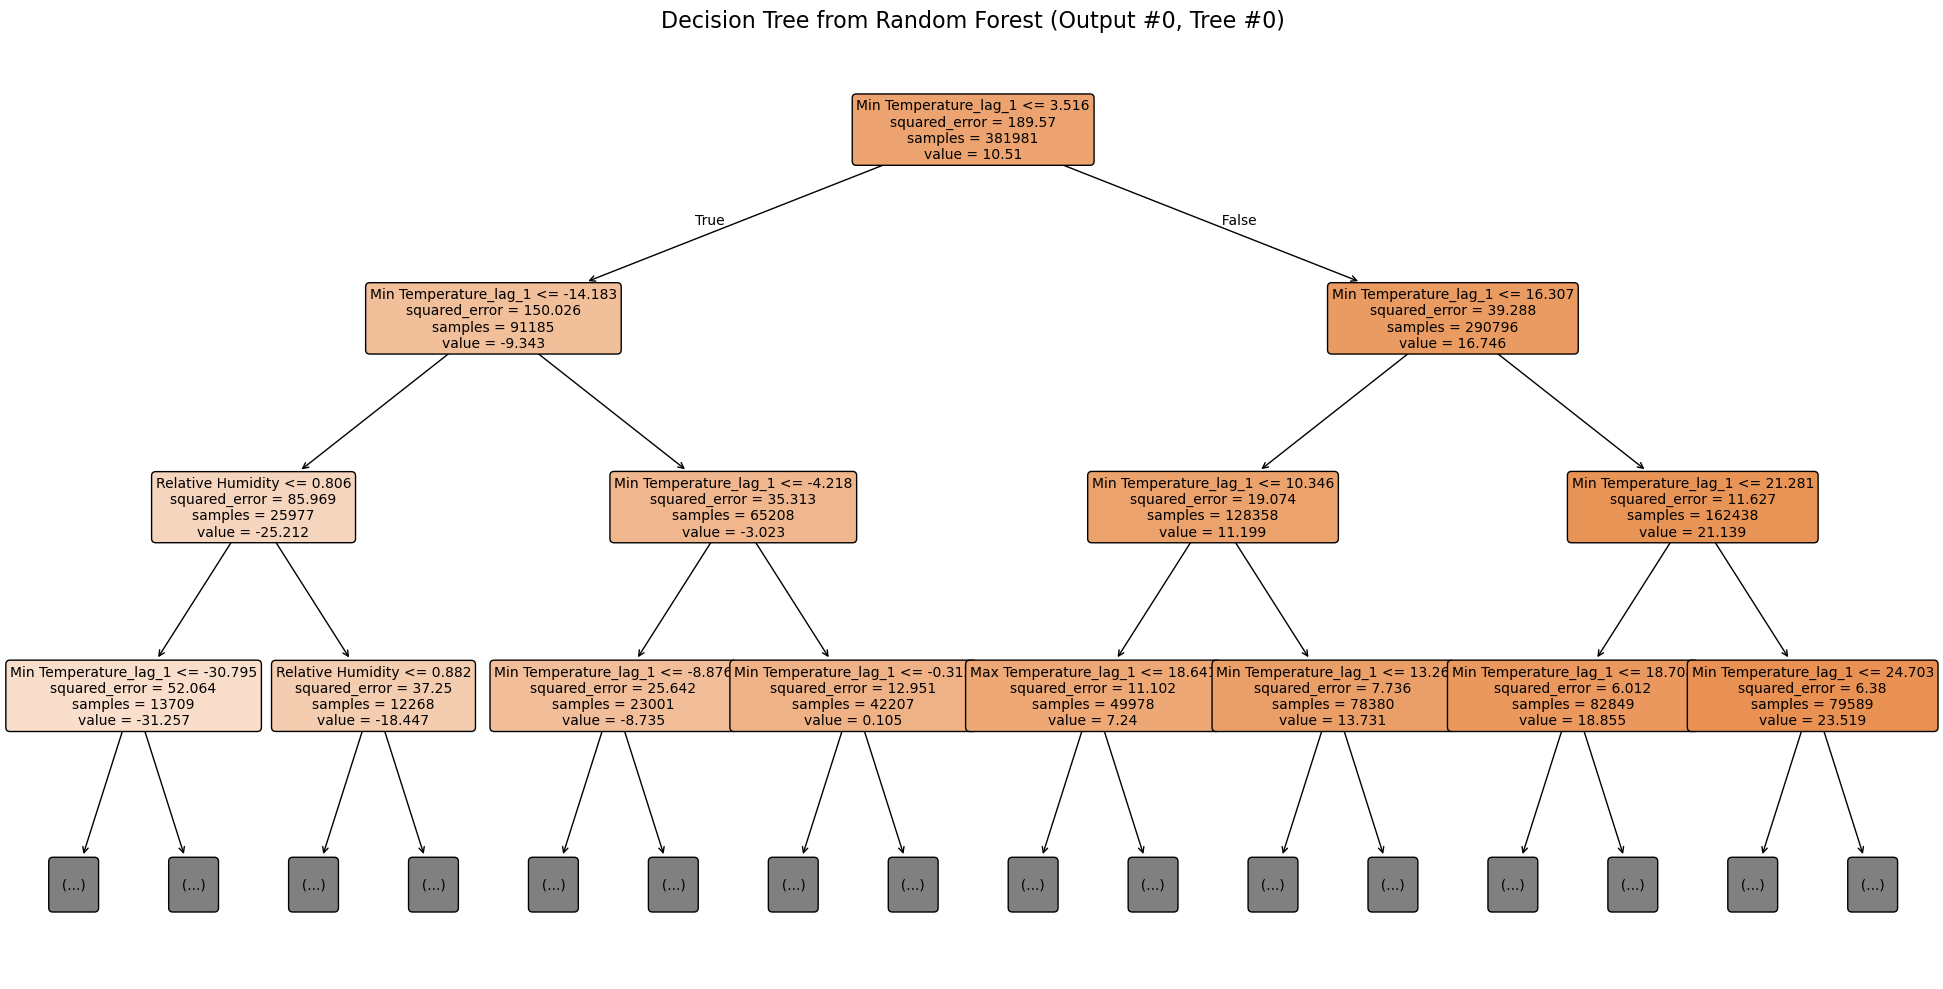

In [55]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Access the RandomForest through the MultiOutputRegressor
# MultiOutputRegressor stores individual estimators in the estimators_ attribute
rf_model = model.estimators_[0]  # Get the first output's RandomForest

# Extract a single tree from that RandomForest
single_tree = rf_model.estimators_[0]  # Get the first tree

# Create plot
plt.figure(figsize=(20, 10))
plot_tree(single_tree, 
          filled=True,
          feature_names=X_train.columns,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Limit depth for readability

plt.title("Decision Tree from Random Forest (Output #0, Tree #0)", fontsize=16)
plt.tight_layout()
plt.show()

Use Nominatim library to find the locations of latitude and longitude coordinates in each of the testing files

In [57]:
from geopy.geocoders import Nominatim

def get_location_details(lat, lon):
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.reverse((lat, lon), language="en")

    if location and 'address' in location.raw:
        address = location.raw['address']
        details = {
            'country': address.get('country'),
            'state': address.get('state'),
            'city': address.get('city') or address.get('town') or address.get('village'),
            'suburb': address.get('suburb'),
            'postcode': address.get('postcode'),
            'full_address': location.address
        }
        return details
    else:
        return None

Use the first test dateframe to visualize the predictions

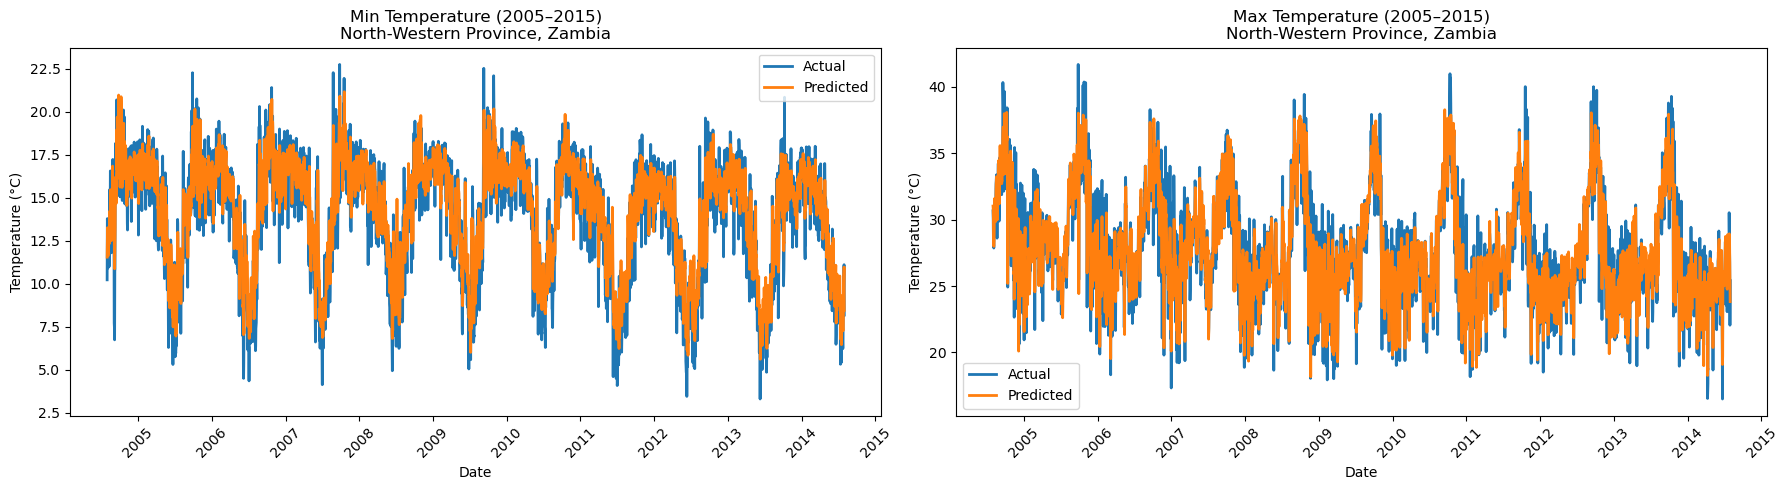

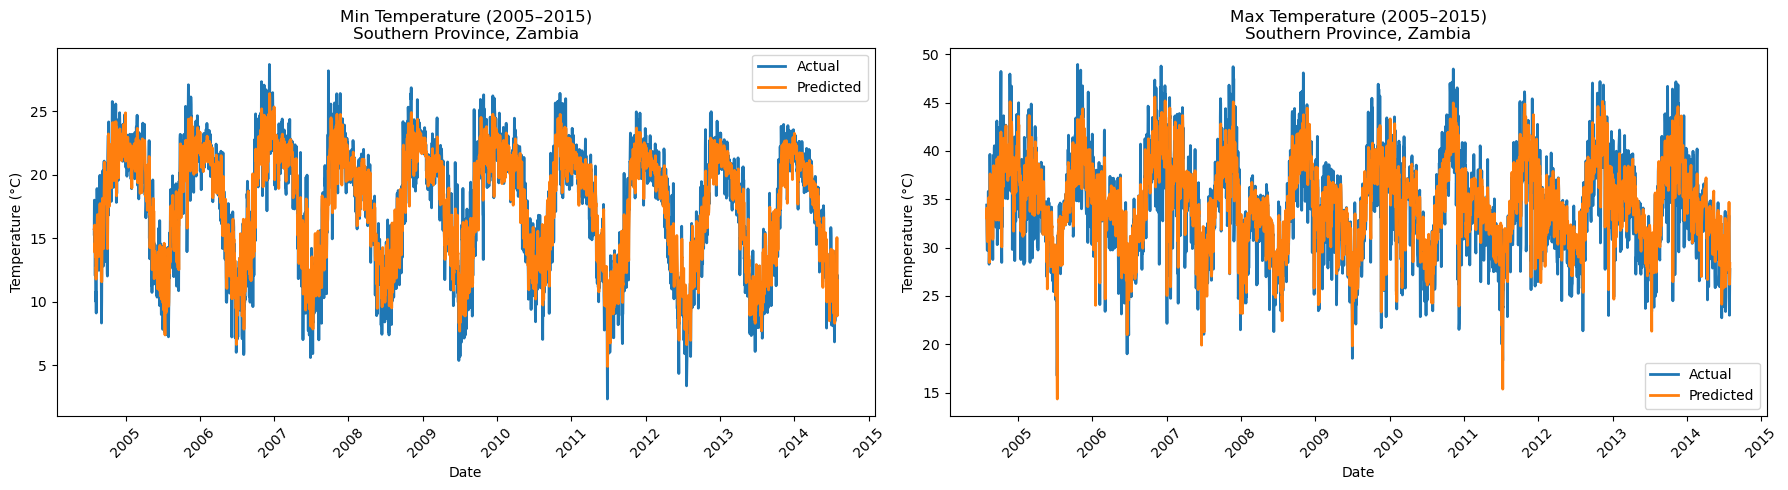

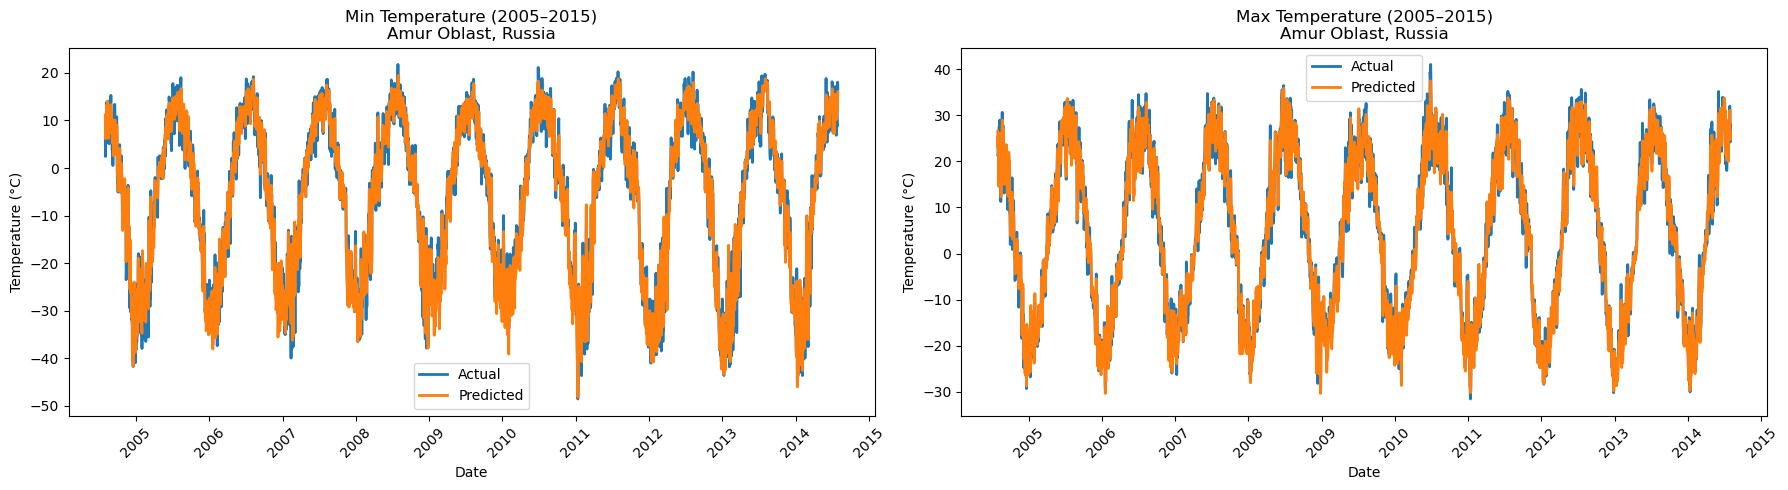

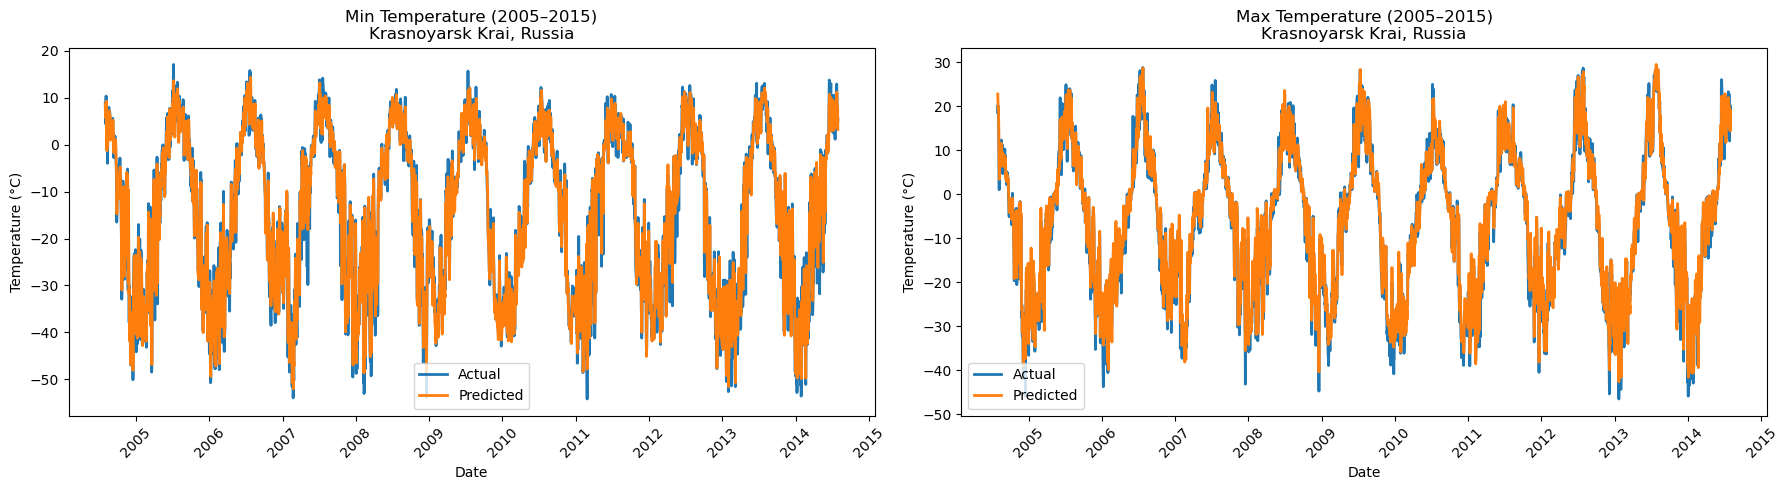

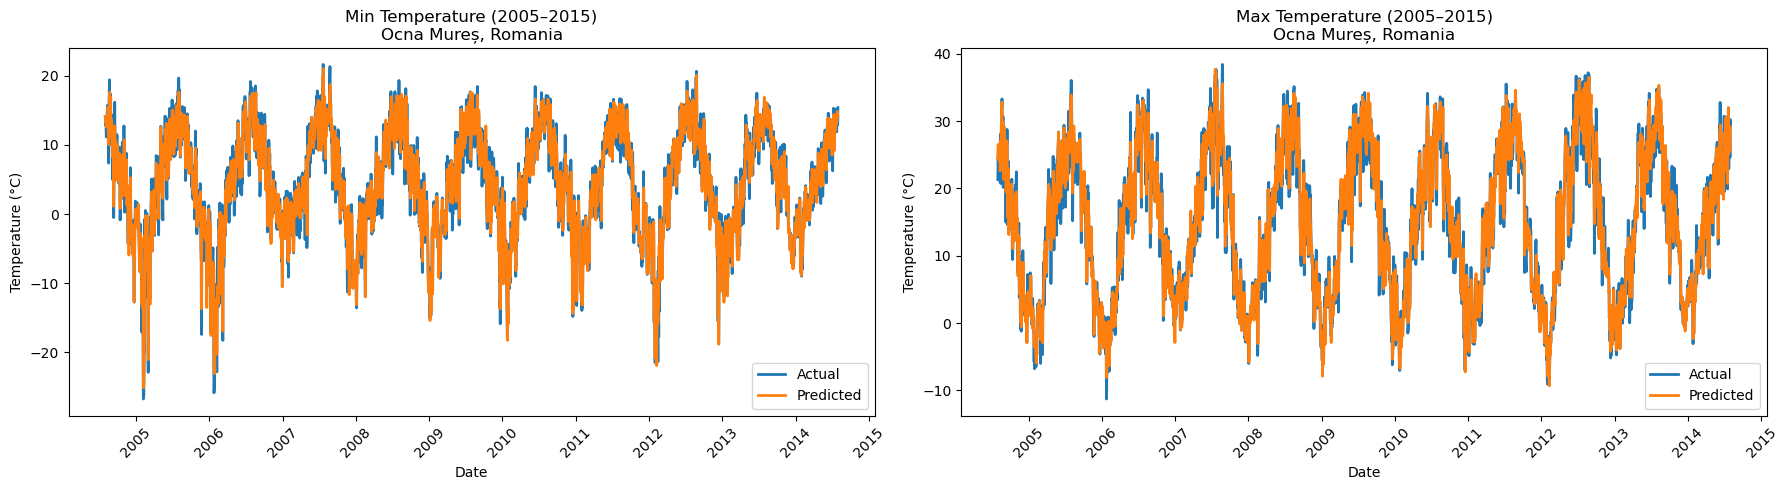

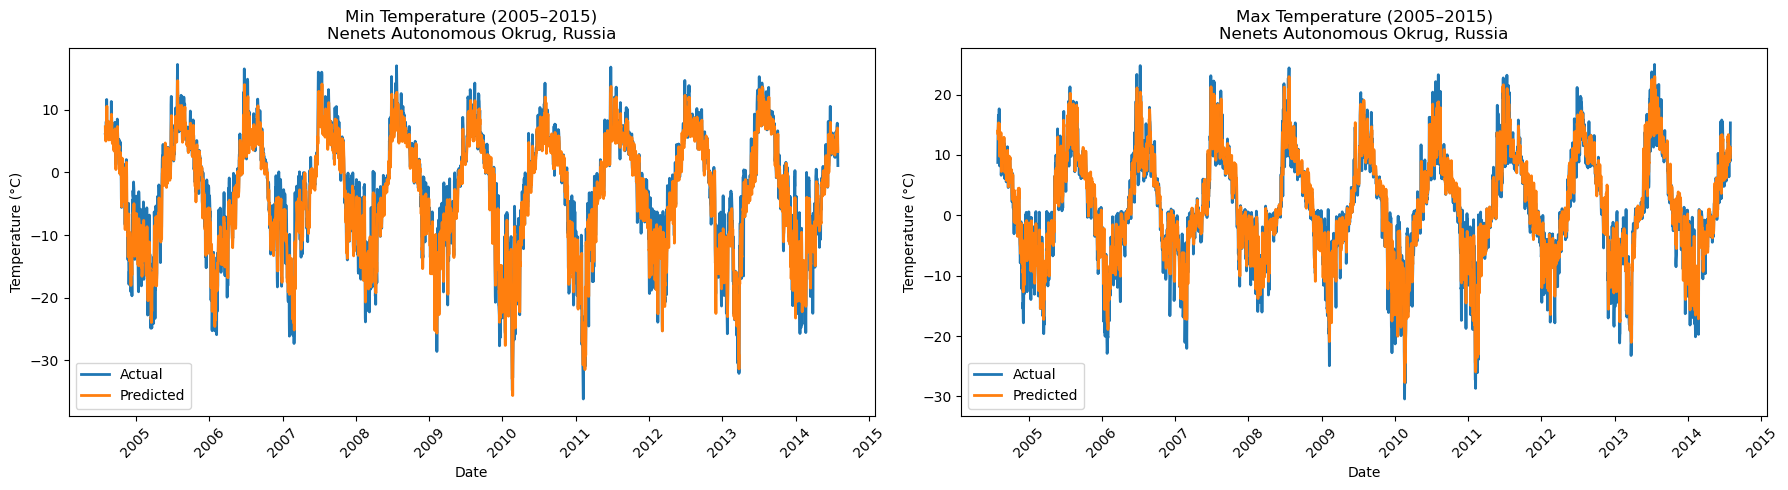

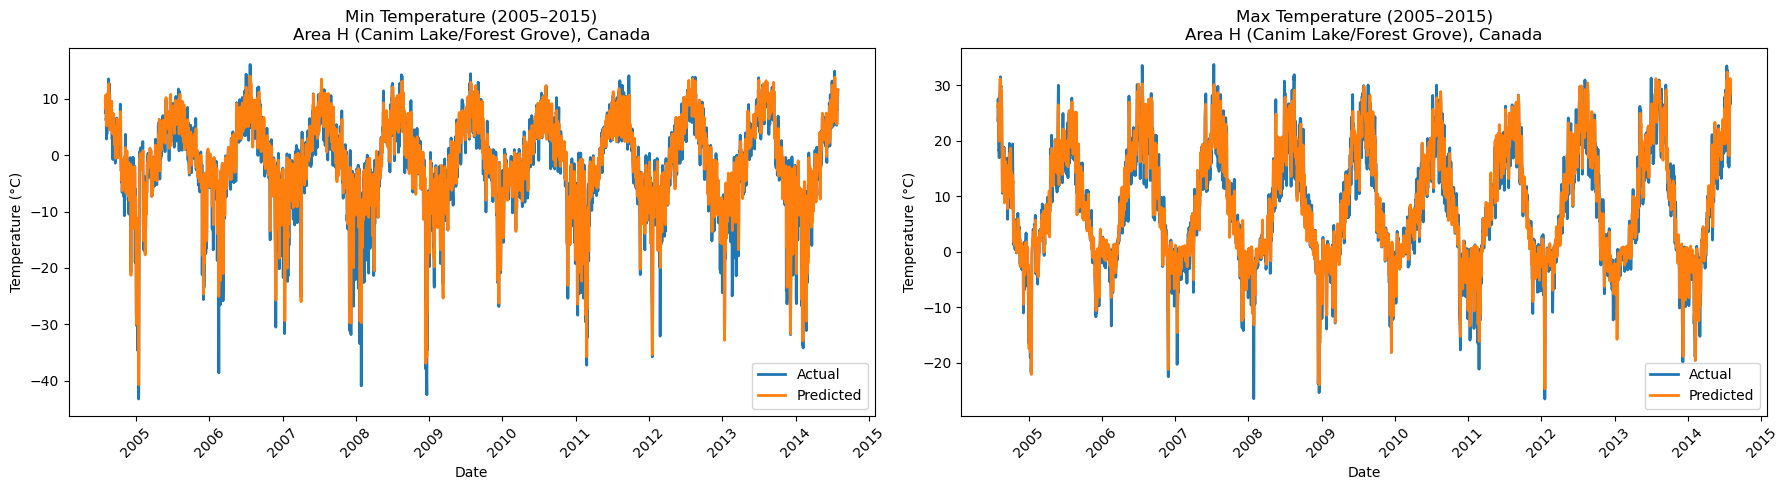

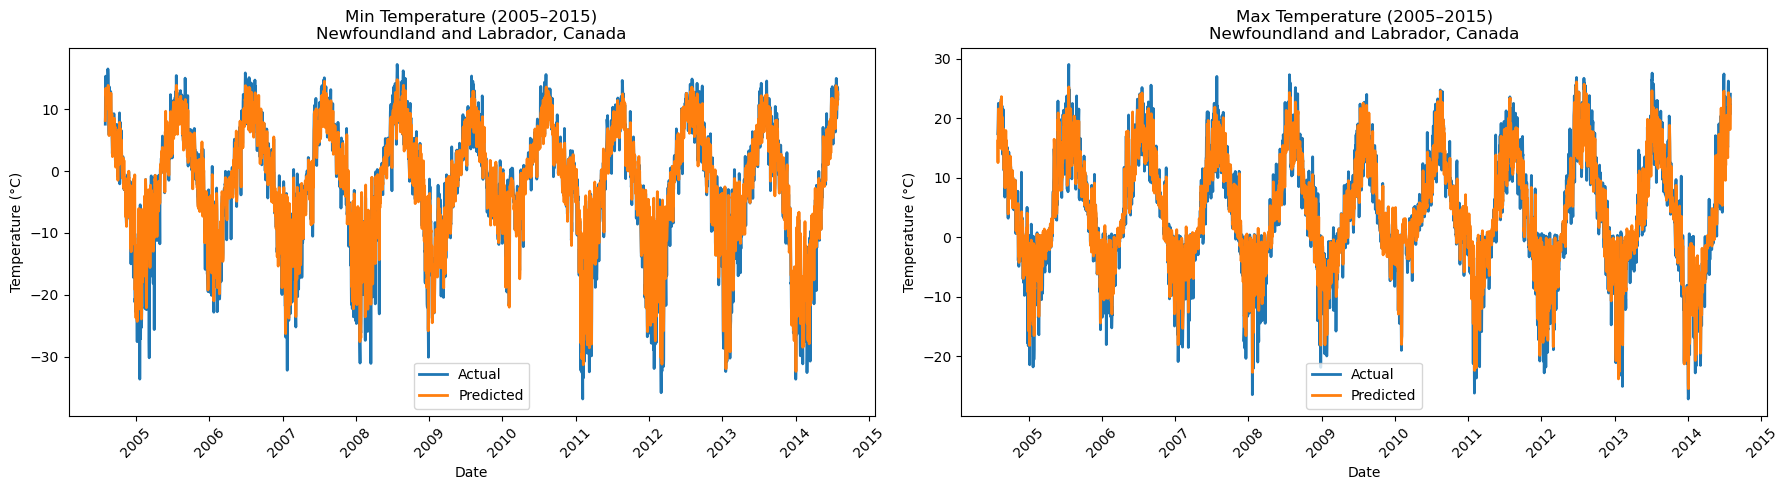

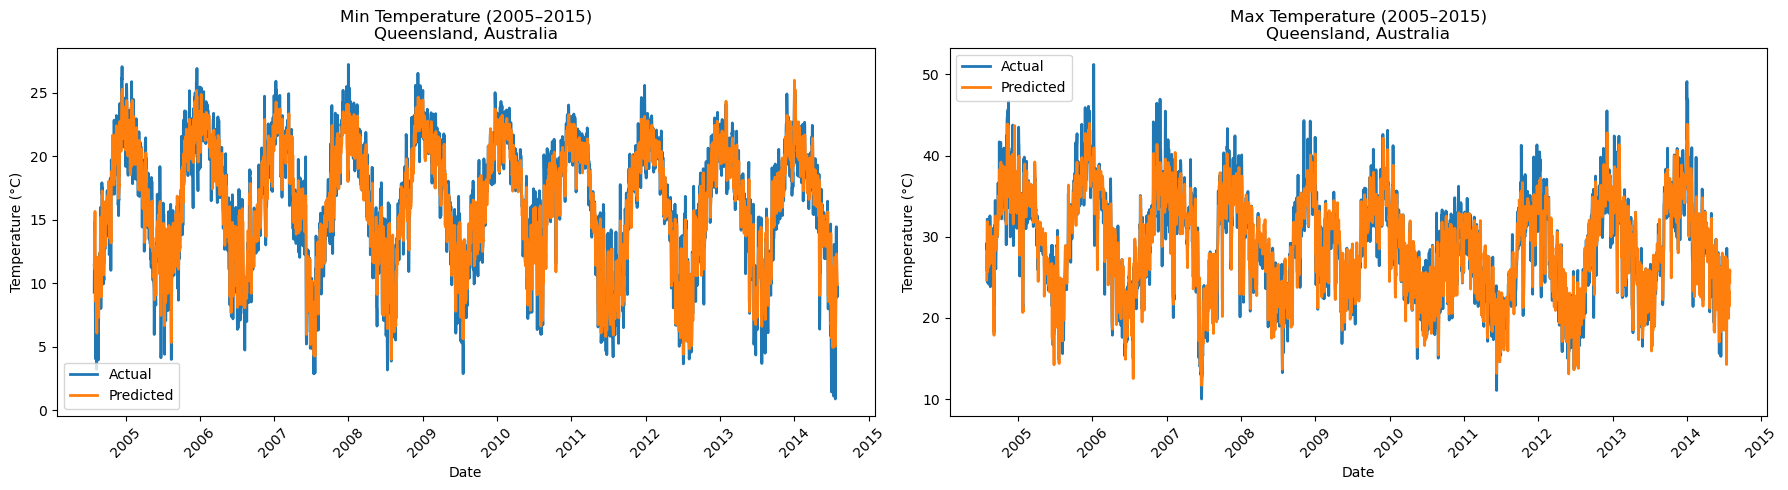

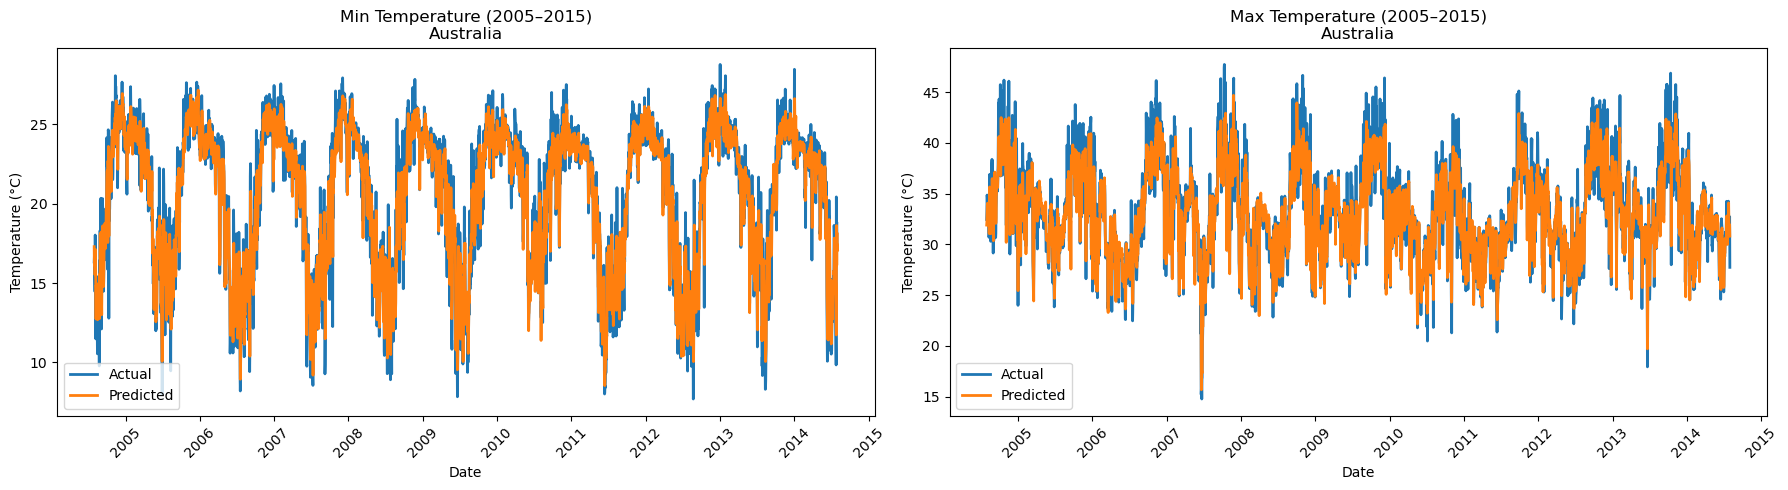

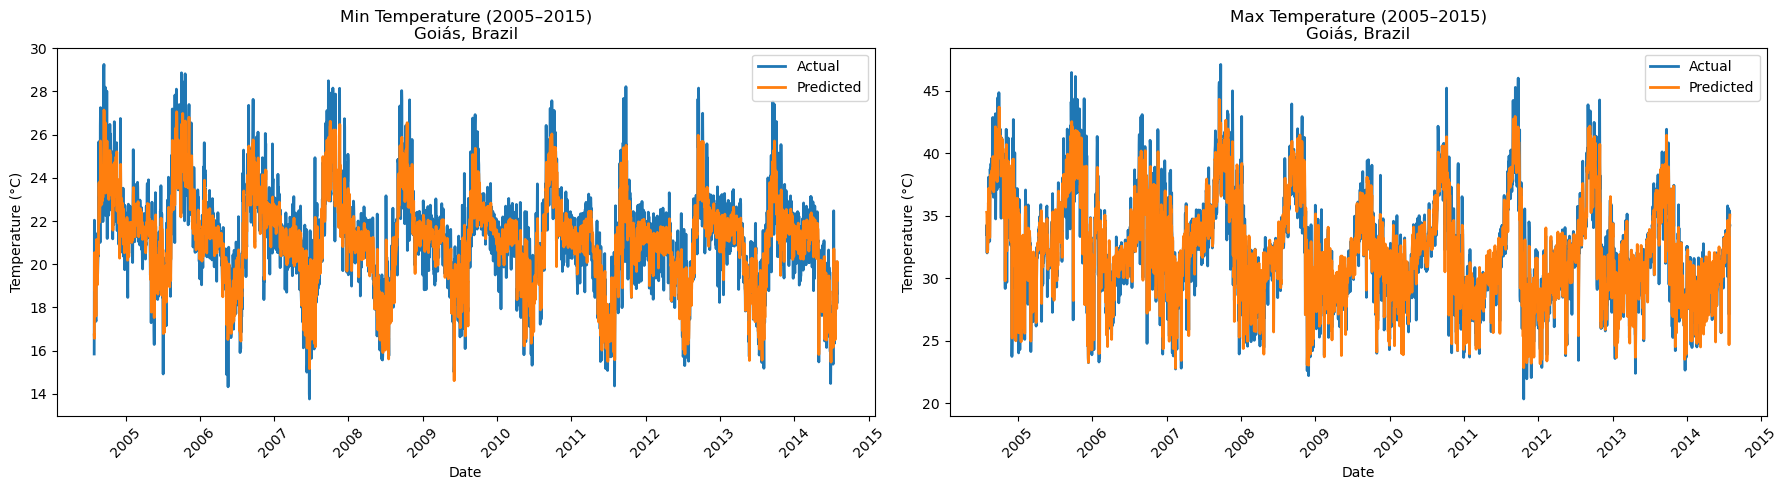

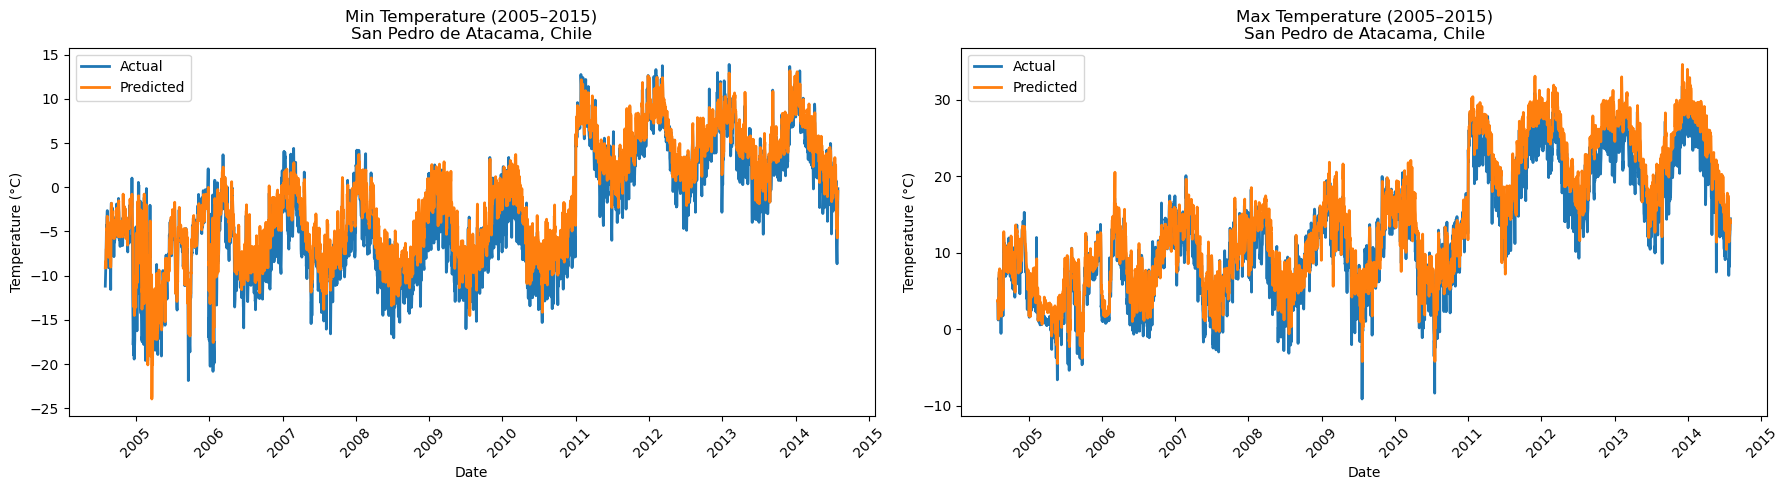

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import os 

for df in test_dfs:
    df['Date'] = pd.to_datetime(df['Date'])
    single_X_test = df[feature_columns]
    single_y_pred = model.predict(single_X_test)

    # --- Get location details ---
    lat = df['Latitude'].iloc[0]
    lon = df['Longitude'].iloc[0]
    location = get_location_details(lat, lon)

    if location:
        city = location.get('city')
        state = location.get('state')
        country = location.get('country')
        suburb = location.get('suburb')

        if city:  # Prefer City + Country
            short_info = f"{city}, {country}"
        elif state:  
            short_info = f"{state}, {country}"
        elif suburb:
            shot_info = f"{suburb}, {country}"
        else:  # If both missing
            short_info = country or "Unknown Location"
    else:
        short_info = "Unknown Location"

    # --- Filter to last 10 years ---
    latest_date = df['Date'].max()
    cutoff_date = latest_date - pd.DateOffset(years=10)
    df_recent = df[df['Date'] >= cutoff_date].reset_index(drop=True)
    single_y_pred_recent = single_y_pred[-len(df_recent):]

    # --- Plot setup ---
    n_targets = len(target_columns)
    fig, axes = plt.subplots(1, n_targets, figsize=(9 * n_targets, 5))
    if n_targets == 1:
        axes = [axes]

    for i, target in enumerate(target_columns):
        axes[i].plot(df_recent['Date'], df_recent[target], label='Actual', linewidth=2)
        axes[i].plot(df_recent['Date'], single_y_pred_recent[:, i], label='Predicted', linewidth=2)
        axes[i].set_title(f'{target} (2005–2015)\n{short_info}', fontsize=12)
        axes[i].set_xlabel('Date')
        axes[i].set_ylabel('Temperature (°C)')
        axes[i].legend()
        axes[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()

    # --- Save plot to file ---
    safe_name = re.sub(r'[\\/*?:"<>|()\s]+', '_', short_info)  # replaces unsafe chars with "_"

    # Optional: define a folder to save plots in
    output_dir = "plots"
    os.makedirs(output_dir, exist_ok=True)
    
    # Create final output path
    output_name = os.path.join(output_dir, f"{safe_name}_comparison.png")
    
    plt.savefig(output_name, dpi=300, bbox_inches='tight')
    plt.show()
    


In [79]:
actual_min = y_test['Min Temperature'].to_numpy()
actual_max = y_test['Max Temperature'].to_numpy()

pred_min = y_test_pred[:,0]
pred_max = y_test_pred[:,1]

In [80]:
for i in range(len(y_test_pred)):
  y_test_pred[i]=np.round(y_test_pred[i],2)
pd.DataFrame({'Actual_Min':actual_min,'Prediction_Min':pred_min,'Min_Diff':(pred_min-actual_min), 'Actual_Max':actual_max,'Prediction_Max':pred_max, 'Max_Diff':(pred_max-actual_max)})

Actual_Min  Prediction_Min  Min_Diff  Actual_Max  Prediction_Max  \
0           13.855           15.04     1.185      26.626           26.75   
1           15.054           14.98    -0.074      27.248           25.37   
2           15.035           15.04     0.005      25.323           25.72   
3           15.046           15.08     0.034      25.530           24.02   
4           16.515           15.21    -1.305      24.099           25.12   
...            ...             ...       ...         ...             ...   
151045      -8.647           -3.84     4.807       8.530           13.78   
151046      -5.301           -5.72    -0.419      12.015           12.91   
151047      -3.686           -1.22     2.466      12.551           14.37   
151048      -3.216           -1.42     1.796      13.790           14.24   
151049      -0.166           -0.47    -0.304      14.432           13.92   

        Max_Diff  
0          0.124  
1         -1.878  
2          0.397  
3         -1.510  
4          1.021  
...          ...  
151045     5.250  
151046     0.895  
151047     1.819  
151048     0.450  
151049    -0.512  

[151050 rows x 6 columns]

# Model Evaluation and Testing

 #### 1. Cross-validation (k-fold)

In [83]:
'''
This section performs 5-fold cross-validation to evaluate the model.
- The dataset is split into 5 equal parts (folds).
- For each fold:
    * The model is trained on 4/5 of the data.
    * The remaining 1/5 is used for testing.
- This process is repeated 5 times, each with a different test fold.
- We collect the R² score (goodness of fit) for each fold.
- Finally, we calculate the mean R² across all folds,
  which gives a more reliable estimate of model performance
  than a single train/test split.
'''
import joblib
model = joblib.load('best_model.pkl')

kf = KFold(n_splits=5, shuffle=False)  
cv_scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

print("Cross-validation R² scores:", cv_scores)
print("Mean CV R²:", np.mean(cv_scores))

Cross-validation R² scores: [0.96210233 0.97086522 0.96255504 0.9764783  0.8853166 ]
Mean CV R²: 0.9514634973836168


#### 2. Key evaluation Matrics (MAE, MAPE,R_SQUARED) 

In [85]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

# --- Define SMAPE function ---
def smape(y_true, y_pred):
    """
    Calculates Symmetric Mean Absolute Percentage Error (SMAPE).
    Safer than MAPE for values near zero.
    Returns % error (0–100 scale).
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    epsilon = 1e-8  # prevents division by zero
    diff = np.abs(y_true - y_pred) / np.maximum(denominator, epsilon)
    return 100 * np.mean(diff)

# --- Model evaluation loop ---
'''
This section evaluates the model’s predictions for each target variable.
- Loops over all target columns (e.g., Max Temp, Min Temp).
- Extracts the true values (y_test) and predicted values (y_test_pred).
- Calculates four key evaluation metrics:
    * MAE   (Mean Absolute Error) - average size of errors in °C.
    * MAPE  (Mean Absolute Percentage Error) - average % error relative to true values.
    * SMAPE (Symmetric Mean Absolute Percentage Error) - more stable % error for near-zero values.
    * R²    (Coefficient of Determination) - how well predictions fit actual values.
- Prints the metrics for each target, formatted for readability.
'''

for i, target in enumerate(target_columns):
    y_true = y_test.iloc[:, i]
    y_pred = y_test_pred[:, i]
    
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    smape_val = smape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{target}:")
    print(f"  MAE   = {mae:.2f} °C")
    print(f"  MAPE  = {mape:.2f} %")
    print(f"  SMAPE = {smape_val:.2f} %")
    print(f"  R²    = {r2:.3f}")


Min Temperature:
  MAE   = 1.68 °C
  MAPE  = 15563581631898.73 %
  SMAPE = 28.42 %
  R²    = 0.976

Max Temperature:
  MAE   = 1.72 °C
  MAPE  = 10614243411816.18 %
  SMAPE = 24.61 %
  R²    = 0.982


#### 3. Model Performance and Error Patterns

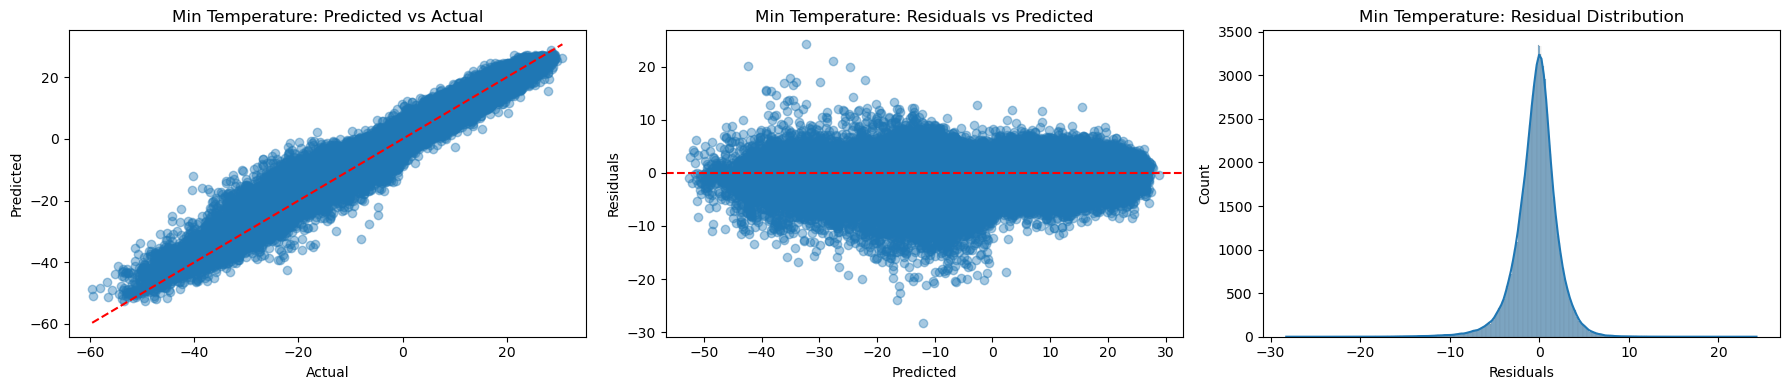

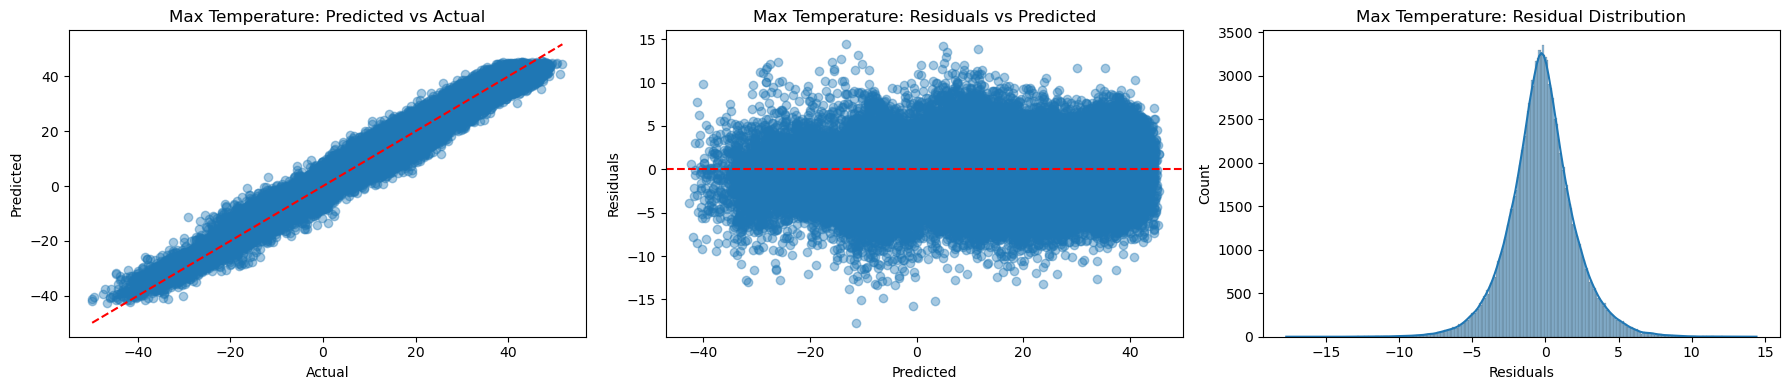

In [87]:
'''
This section generates diagnostic plots for each target variable.
The goal is to visually check model performance and error patterns:
1. Predicted vs Actual (parity plot):
   - Compares true vs predicted values.
   - Points close to the red diagonal line = good predictions.
2. Residuals vs Predicted:
   - Plots errors (residuals) against predicted values.
   - Should look like random scatter around 0 (no visible pattern).
   - Patterns/trends would suggest model bias.
3. Residual Distribution (histogram + KDE):
   - Shows how residuals are distributed.
   - A roughly symmetric bell-shaped curve centered at 0 is ideal.
'''

for i, target in enumerate(target_columns):
    y_true = y_test.iloc[:, i]
    y_pred = y_test_pred[:, i]
    residuals = y_true - y_pred

    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    
    # Predicted vs Actual (parity plot)
    ax[0].scatter(y_true, y_pred, alpha=0.4)
    ax[0].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    ax[0].set_title(f"{target}: Predicted vs Actual")
    ax[0].set_xlabel("Actual")
    ax[0].set_ylabel("Predicted")
    
    # Residuals vs Predicted
    ax[1].scatter(y_pred, residuals, alpha=0.4)
    ax[1].axhline(0, color='r', linestyle='--')
    ax[1].set_title(f"{target}: Residuals vs Predicted")
    ax[1].set_xlabel("Predicted")
    ax[1].set_ylabel("Residuals")
    
    # Histogram of Residuals
    sns.histplot(residuals, kde=True, ax=ax[2])
    ax[2].set_title(f"{target}: Residual Distribution")
    ax[2].set_xlabel("Residuals")
    
    plt.tight_layout()
    plt.show()

#### 4. Feature Importance 

In [89]:
'''
Feature Importances for MultiOutput Random Forest (clean Top-N plots)

What this does:
- Works whether our model is a bare RandomForestRegressor, a Pipeline, or a
  MultiOutputRegressor(RandomForestRegressor).
- For multi-output, it extracts the Random Forest used for each target and
  plots a separate Top-N importance chart (so labels don't overlap).
- For single "overall" view, it also computes an average importance
  across targets (optional: set `PLOT_OVERALL=True`).

Requirements:
- `model` is our fitted model
- `feature_columns` is a list of input feature names in the same order as X
- `target_columns` is a list of our target names (e.g., ["Max Temp", "Min Temp"])
'''

from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# how many top features to show per target
# also shows an averaged-importance plot across all targets
top_n = 15          
plot_overall = True 

In [90]:
def _get_final_estimator(m):
    """Return the final estimator if `m` is a Pipeline; else return `m`."""
    if isinstance(m, Pipeline):
        # Try common names, otherwise just take the last step
        if 'regressor' in m.named_steps:
            return m.named_steps['regressor']
        return list(m.named_steps.values())[-1]
    return m

def _get_rf_for_target(model, target_idx=0):
    """
    Given a possibly wrapped model, return the RandomForestRegressor
    used for the specified target index.
    """
    base = _get_final_estimator(model)
    if isinstance(base, MultiOutputRegressor):
        est = base.estimators_[target_idx]
        # in case each sub-estimator is also a Pipeline
        return _get_final_estimator(est)  
    # single-output case
    return base

def _get_feature_importances_for_target(model, target_idx):
    """Returning a numpy array of feature importances for a given target index."""
    rf = _get_rf_for_target(model, target_idx)
    if not hasattr(rf, "feature_importances_"):
        raise AttributeError("Underlying estimator does not expose .feature_importances_. "
                             "Ensure you are using RandomForestRegressor (or similar).")
    return rf.feature_importances_

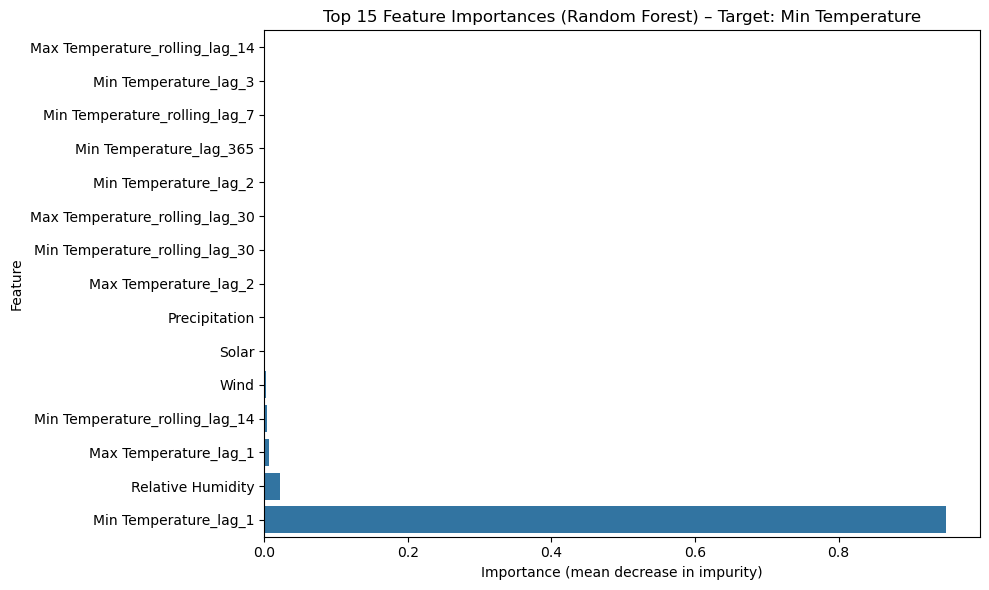

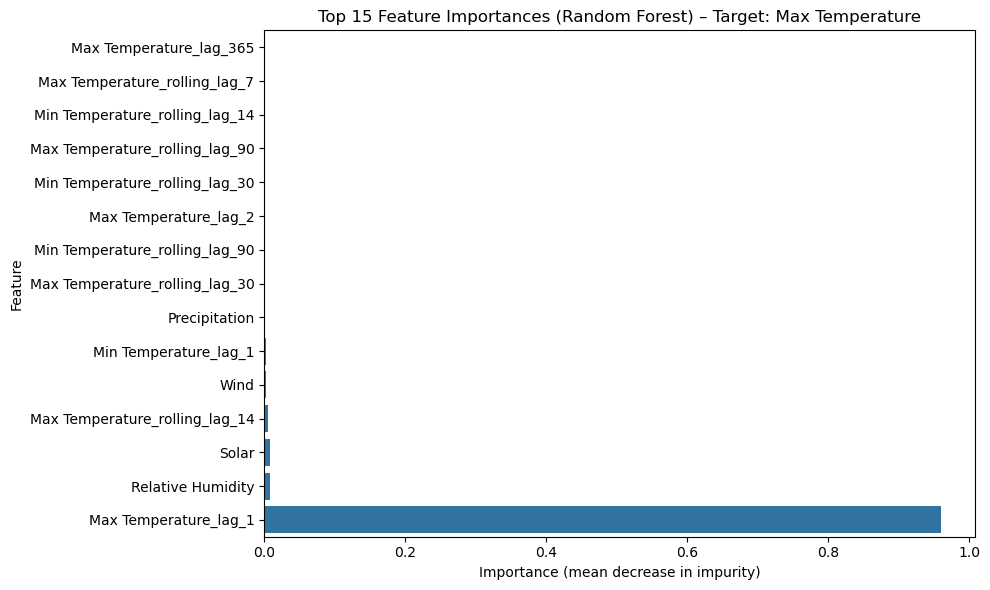

In [91]:

# Per-target plots

for i, target in enumerate(target_columns):
    # 1) fetching importances for this target
    importances = _get_feature_importances_for_target(model, i)

    # 2) mapping to feature names and sort
    feat_imp = pd.Series(importances, index=feature_columns).sort_values(ascending=False)

    # 3) keeping only Top-N for readability
    top_feat_imp = feat_imp.head(top_n).iloc[::-1]  

    # 4) plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_feat_imp.values, y=top_feat_imp.index)
    plt.title(f"Top {top_n} Feature Importances (Random Forest) – Target: {target}")
    plt.xlabel("Importance (mean decrease in impurity)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

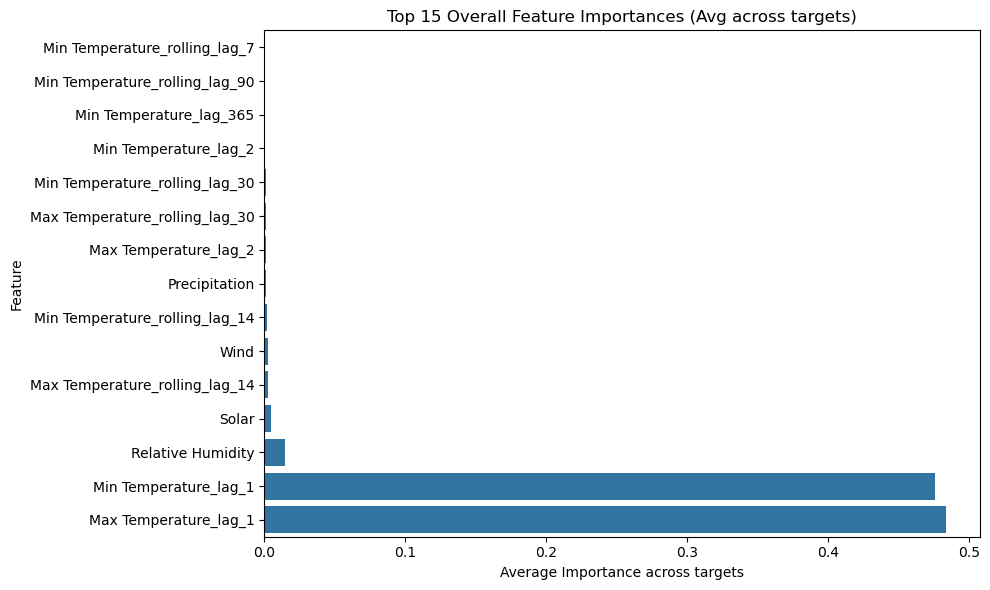

In [92]:

# Overall (average across targets)

if plot_overall:
    # If single-output, this still works (len(target_columns) == 1)
    all_imps = []
    for i in range(len(target_columns)):
        all_imps.append(_get_feature_importances_for_target(model, i))
    # shape: [n_targets, n_features]
    all_imps = np.vstack(all_imps)  
    mean_imp = all_imps.mean(axis=0)

    overall = pd.Series(mean_imp, index=feature_columns).sort_values(ascending=False)
    top_overall = overall.head(top_n).iloc[::-1]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_overall.values, y=top_overall.index)
    plt.title(f"Top {top_n} Overall Feature Importances (Avg across targets)")
    plt.xlabel("Average Importance across targets")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

## Learning Curve (Bias vs Variance check)

Shows training vs validation error as training size increases.
Helps detect overfitting/underfitting.

In [ ]:
''''
Learning Curve for Random Forest using KFold Cross-Validation

Purpose:
- Shows how Random Forest performance (R² or RMSE) changes as the training set grows.
- Helps detect underfitting (both scores low), overfitting (big gap between curves),
  or if adding more data keeps improving validation performance.

How the code works:
1. Defining training set sizes as fractions (10% → 100% of training data).
2. Using sklearn's learning_curve function:
   - Splits training data into folds using KFold cross-validation.
   - For each fraction of data, fits the model on that subset.
   - Computes both training and validation scores across folds.
3. Average scores across folds and plot the results.
4. Plot:
   - Training curve = model fit quality on subsets it was trained on.
   - Validation curve = generalization performance on unseen folds.
'''


from sklearn.model_selection import learning_curve

estimator = model  
train_sizes = np.linspace(0.1, 1.0, 5)

# R²-based learning curve (averages across targets for multi-output)
train_sizes, train_scores, val_scores = learning_curve(
    estimator=estimator,
    X=X_train, y=y_train,
    cv=kf,
    scoring="r2",
    train_sizes=train_sizes,
    n_jobs=-1,        
    verbose=1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, marker="o", label="Training R²")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.plot(train_sizes, val_mean, marker="o", label="Validation R²")
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.xlabel("Training set size"); plt.ylabel("R²")
plt.title("Learning Curve — Random Forest (KFold)")
plt.legend(); plt.grid(True)
plt.show()


[learning_curve] Training set sizes: [ 48335 157090 265845 374600 483355]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [ ]:
'''
Learning Curve for Random Forest using KFold Cross-Validation (RMSE version)

Purpose:
- Tracks model error (Root Mean Squared Error) as the training set grows.
- RMSE is easier to interpret since it’s in the same units as the target variable.
- Helps identify if the model benefits from more data or if it overfits.

How the code works:
1. Define training set sizes as fractions (10% → 100% of training data).
2. Using sklearn's learning_curve function:
   - Splits training data into folds using KFold cross-validation.
   - For each fraction, fits the model on that subset.
   - Computes negative MSE scores .
3. Convert negative MSE into RMSE (take square root of positive MSE).
4. Average RMSE across folds for training and validation sets.
5. Plot curves to compare training vs validation error.

Interpretation:
- Training RMSE low & Validation RMSE high → overfitting.
- Both RMSE high & close together → underfitting.
- Both RMSE decreasing and converging → healthy learning, more data still helps.
'''

train_sizes = np.linspace(0.1, 1.0, 8)

train_sizes, train_scores, val_scores = learning_curve(
    estimator=estimator,
    X=X_train, y=y_train,
    cv=kf,
    scoring="neg_mean_squared_error",
    train_sizes=train_sizes,
    n_jobs=1
)

train_rmse = np.sqrt((-train_scores).mean(axis=1))
val_rmse   = np.sqrt((-val_scores).mean(axis=1))

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_rmse, marker="o", label="Training RMSE")
plt.plot(train_sizes, val_rmse, marker="o", label="Validation RMSE")
plt.xlabel("Training set size"); plt.ylabel("RMSE")
plt.title("Learning Curve (RMSE) — Random Forest (KFold)")
plt.legend(); plt.grid(True)
plt.show()


In [ ]:
unseen_df = pd.read_csv("unseen_testdata_15rows.csv")
print(unseen_df.shape)
unseen_df.head()

In [ ]:
# Defining the same feature list used in training
feature_columns = [
    'Precipitation(mm)', 'Wind(km/h)', 'Relative Humidity', 'Solar(W/m²)', 
    'Month', 'Day Of Year', 'Month Sin', 'Month Cos', 'Day Of Year Sin', 'Day Of Year Cos',
    'Min Temperature(°C)_lag_1', 'Max Temperature(°C)_lag_1', 
    'Min Temperature(°C)_lag_2', 'Max Temperature(°C)_lag_2',
    'Min Temperature(°C)_lag_3', 'Max Temperature(°C)_lag_3',
    'Min Temperature(°C)_rolling_lag_7', 'Max Temperature(°C)_rolling_lag_7',
    'Min Temperature(°C)_rolling_lag_14', 'Max Temperature(°C)_rolling_lag_14',
    'Min Temperature(°C)_rolling_lag_30', 'Max Temperature(°C)_rolling_lag_30',
    'Extreme_Days_Max Temperature(°C)', 'Extreme_Days_Min Temperature(°C)', 
    'Extreme_Days_Precipitation(mm)', 'Extreme_Days_Wind(km/h)',
    'Solar_Humidity', 'Solar_Wind', 'Humidity_Wind', 'Rain_Humidity'
]

# Selecting feature data
X_unseen = unseen_df[feature_columns]

In [ ]:
# Predicting for unseen data
y_pred_unseen = model.predict(X_unseen)

# Convering predictions to DataFrame
predictions = pd.DataFrame(y_pred_unseen, columns=['Pred_Min_Temp(°C)', 'Pred_Max_Temp(°C)'])

# Combining with Date for clarity
results = pd.concat([unseen_df[['Date']], predictions], axis=1)

# Display results
print("15-Day Unseen Data Predictions:")
print(results)

In [ ]:
y_train.head()